# $U(1)$ Gauge Model using L2HMC in graph mode

--------------------------------------------------------------------
### TODO:
* [ ] Look at performance on Cooley (longer training runs).
* [ ] Fit observables to Eq. \ref{eq:therm_time} to determine the thermalization time $\tau$.

\begin{equation} 
f(t) \equiv A \exp^{-t / \tau}+ \,\, B
\label{eq:therm_time}
\end{equation}
* [ ] Look at defining a distance metric as the difference in topological charge between two samples and see what effect adding this as an additional term to the loss function has on the models' ability to tunnel between topological sectors.

--------------------------------------------------------------------

In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.gauge_model_helpers as helpers
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)
from gauge_model import (
    GaugeModel, check_else_make_dir, save_params_to_pkl_file
)

tfe = tf.contrib.eager
%autoreload 2
%matplotlib notebook

#from gauge_model import GaugeModel
#%reload_ext gauge_model.GaugeModel
#from gauge_model import GaugeModel
#
#from dynamics.gauge_dynamics import GaugeDynamics
#%reload_ext dynamics.gauge_dynamics
#from dynamics.gauge_dynamics import GaugeDynamics

## Define parameters

In [2]:
params = {
#--------------------- Lattice parameters ----------------------------
    'time_size': 16,
    'space_size': 16,
    'link_type': 'U1',
    'dim': 2,
    'num_samples': 4,
    'rand': False,
#--------------------- Leapfrog parameters ---------------------------
    'num_steps': 2,
    'eps': 0.2,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
#--------------------- Learning rate parameters ----------------------
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 500,
    'learning_rate_decay_rate': 0.96,
#--------------------- Annealing rate parameters ---------------------
    'annealing': True,
    'annealing_steps': 500,
    'annealing_factor': 0.9999,
    #'beta': 3.,
    'beta_init': 3.,
    'beta_final': 8.,
#--------------------- Training parameters ---------------------------
    'train_steps': 20000,
    'save_steps': 1000,
    'logging_steps': 50,
    'training_samples_steps': 1000,
    'training_samples_length': 100,
#--------------------- Model parameters ------------------------------
    'conv_net': True,
    'hmc': False,
    'eps_trainable': True,
    'metric': 'l2',
    'aux': True,
    'clip_grads': False,
    'clip_value': 10.,
}

## Create model

In [3]:
#os.environ["KMP_BLOCKTIME"] = str(0)
#os.environ["KMP_SETTINGS"] = str(1)
#os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"
#os.environ["OMP_NUM_THREADS"] = str(2)

config = tf.ConfigProto()
tf.reset_default_graph()

In [4]:
model = GaugeModel(params=params, 
                   config=config,
                   sess=None,
                   log_dir=None,
                   restore=False)

save_params_to_pkl_file(params, model.info_dir)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history.
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/training.
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/train_samples.
time_size: 16
space_size: 16
link_type: U1
dim: 2
num_samples: 4
rand: False
num_steps: 1
eps: 0.2
loss_scale: 0.1
loss_eps: 0.0001
learning_rate_init: 0.001
learning_rate_decay_steps: 500
learning_rate_decay_rate: 0.96
annealing: True
annealing_steps: 500
annealing_factor: 0.9999
beta_init: 3.0
beta_final: 8.0
train_steps: 20000
save_steps: 1000
logging_steps: 50
training_samples_steps: 1000
training_samples_length: 100
conv_net: True
hmc: False
eps_trainable: True
metric: l2
aux: True
clip_grads: False
clip_value: 10.0
--------------------------------------------------------------------------------

Building graph... (started at: Tue Feb  

In [5]:
model.train(model.train_steps, kill_sess=False)

----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
     0/20000    -1.018e+05       395.4       4.954e-05        0.2            3           0.001    
     1/20000    -1.019e+05      0.7461       8.889e-05       0.201           3           0.001    
     2/20000    -1.006e+05      0.4073       0.0001787      0.2011         3.001         0.001    
     3/20000    -5.563e+04      0.4036       0.0001305      0.2006         3.001         0.001    
     4/20000    -8.709e+04      0.3767       2.013e-05      0.2012         3.001         0.001    
     5/20000    -8.196e+04      0.4267       0.0005913      0.2019         3.002         0.001    
     6/20000    -9.889e+04      0.4261       6.827e-05      0.2026         3.002         0.001    
     

    80/20000    -1.056e+05      0.4627        0.3282         0.209         3.024         0.001    
    81/20000    -1.071e+05      0.4739        0.3139         0.209         3.024         0.001    
    82/20000    -1.119e+05       0.48         0.5004        0.2089         3.025         0.001    
    83/20000    -1.157e+05      0.4432        0.7505        0.2088         3.025         0.001    
    84/20000    -1.016e+05      0.4123        0.01593       0.2088         3.025         0.001    
    85/20000    -1.013e+05      0.4116        0.01614       0.2087         3.026         0.001    
    86/20000    -1.043e+05      0.4196        0.2627        0.2089         3.026         0.001    
    87/20000    -1.039e+05      0.4321        0.3335        0.2091         3.026         0.001    
    88/20000    -1.096e+05      0.4415        0.5065        0.2092         3.027         0.001    
    89/20000    -1.091e+05       0.397         0.539        0.2093         3.027         0.001    
    90/200

   163/20000    -1.135e+05      0.4758        0.7631        0.1965         3.049         0.001    
   164/20000    -1.081e+05      0.4338        0.7953        0.1963         3.05          0.001    
   165/20000     -1.05e+05      0.5182        0.3432        0.1961         3.05          0.001    
   166/20000    -1.071e+05      0.4843        0.3152        0.1958         3.05          0.001    
   167/20000    -1.131e+05      0.4286        0.7309        0.1956         3.051         0.001    
   168/20000    -1.108e+05      0.4276        0.7534        0.1953         3.051         0.001    
   169/20000    -1.048e+05      0.4771        0.4397        0.1951         3.051         0.001    
   170/20000    -1.122e+05      0.5094        0.7527        0.1949         3.051         0.001    
   171/20000     -1.07e+05      0.4481        0.6067        0.1947         3.052         0.001    
   172/20000    -1.016e+05      0.4768        0.3048        0.1945         3.052         0.001    
   173/200

   246/20000    -1.033e+05      0.4203         0.646        0.1811         3.075         0.001    
   247/20000    -1.056e+05      0.4211        0.5247        0.1809         3.075         0.001    
   248/20000    -1.079e+05       0.407        0.6515        0.1806         3.075         0.001    
   249/20000    -1.086e+05       0.41         0.4896        0.1803         3.076         0.001    
   250/20000    -9.842e+04      0.4443        0.3601         0.18          3.076         0.001    
   251/20000    -1.065e+05       0.439        0.6017        0.1798         3.076         0.001    
   252/20000    -1.038e+05      0.4799        0.3881        0.1795         3.077         0.001    
   253/20000    -1.065e+05      0.5124         0.508        0.1793         3.077         0.001    
   254/20000    -1.071e+05      0.4807        0.7017         0.179         3.077         0.001    
   255/20000    -1.048e+05      0.4354        0.5147        0.1788         3.077         0.001    
   256/200

   329/20000    -1.071e+05      0.3999        0.3635        0.1642          3.1          0.001    
   330/20000    -1.051e+05      0.4288        0.8404         0.164         3.101         0.001    
   331/20000    -1.042e+05      0.4036        0.4489        0.1638         3.101         0.001    
   332/20000    -1.048e+05      0.3946        0.8378        0.1636         3.101         0.001    
   333/20000    -1.039e+05      0.4172        0.6353        0.1635         3.102         0.001    
   334/20000    -1.019e+05       0.392         0.51         0.1633         3.102         0.001    
   335/20000     -1.03e+05      0.3791         0.53         0.1631         3.102         0.001    
   336/20000    -1.049e+05      0.3849        0.6283        0.1629         3.103         0.001    
   337/20000    -1.076e+05      0.3753        0.4624        0.1627         3.103         0.001    
   338/20000    -1.012e+05      0.3884        0.4762        0.1625         3.103         0.001    
   339/200

   412/20000    -1.045e+05       0.471         0.735        0.1504         3.126         0.001    
   413/20000    -1.048e+05      0.4341        0.8573        0.1502         3.127         0.001    
   414/20000    -1.068e+05      0.4106        0.5356         0.15          3.127         0.001    
   415/20000    -1.045e+05      0.8252        0.5776        0.1499         3.127         0.001    
   416/20000    -1.033e+05      0.4473        0.7306        0.1497         3.127         0.001    
   417/20000    -1.076e+05      0.3627        0.8408        0.1495         3.128         0.001    
   418/20000    -1.079e+05      0.3564        0.6765        0.1494         3.128         0.001    
   419/20000    -1.045e+05      0.3917        0.7391        0.1492         3.128         0.001    
   420/20000    -1.039e+05      0.3881        0.7467         0.149         3.129         0.001    
   421/20000    -1.018e+05       0.424        0.5509        0.1489         3.129         0.001    
   422/200

   495/20000    -1.085e+05      0.4737        0.6694        0.1485         3.152         0.001    
   496/20000    -1.038e+05       0.586         0.634        0.1484         3.153         0.001    
   497/20000    -1.067e+05      0.5522        0.8625        0.1484         3.153         0.001    
   498/20000    -1.073e+05      0.5638        0.6488        0.1483         3.153         0.001    
   499/20000    -1.066e+05      0.4558        0.7064        0.1482         3.154         0.001    
   500/20000    -9.764e+04      0.4107        0.8681        0.1482         3.154        0.00096   
   501/20000    -1.108e+05      0.5691        0.8875        0.1483         3.154        0.00096   
   502/20000    -1.028e+05      0.5941        0.3469        0.1484         3.154        0.00096   
   503/20000    -1.018e+05       0.602        0.5595        0.1485         3.155        0.00096   
   504/20000    -1.013e+05      0.6371        0.5976        0.1485         3.155        0.00096   
   505/200

   578/20000     -1.05e+05      0.4235        0.6064        0.1398         3.179        0.00096   
   579/20000    -1.024e+05      0.4064         0.895        0.1397         3.179        0.00096   
   580/20000    -1.038e+05      0.4055        0.7314        0.1396         3.179        0.00096   
   581/20000     -1.08e+05      0.4365        0.8512        0.1395         3.179        0.00096   
   582/20000    -1.078e+05      0.4363        0.6113        0.1394         3.18         0.00096   
   583/20000    -9.792e+04      0.3976        0.8963        0.1393         3.18         0.00096   
   584/20000    -1.051e+05      0.4396        0.7065        0.1391         3.18         0.00096   
   585/20000    -1.056e+05      0.4134           1           0.139         3.181        0.00096   
   586/20000    -1.029e+05      0.4259        0.7285        0.1389         3.181        0.00096   
   587/20000    -1.069e+05       0.409        0.6924        0.1388         3.181        0.00096   
   588/200

   661/20000    -1.005e+05      0.4191        0.6284        0.1429         3.205        0.00096   
   662/20000    -1.058e+05      0.5537        0.7923        0.1429         3.205        0.00096   
   663/20000    -1.152e+05      0.6333           1           0.143         3.206        0.00096   
   664/20000     -1.02e+05      0.4984        0.8153         0.143         3.206        0.00096   
   665/20000    -1.077e+05      0.5625        0.5088        0.1431         3.206        0.00096   
   666/20000    -9.975e+04       0.469         0.534        0.1431         3.207        0.00096   
   667/20000    -1.061e+05      0.4818        0.6206        0.1431         3.207        0.00096   
   668/20000    -1.062e+05      0.4722        0.7564         0.143         3.207        0.00096   
   669/20000    -1.007e+05      0.4601        0.6249         0.143         3.208        0.00096   
   670/20000    -1.024e+05      0.7975        0.5087        0.1429         3.208        0.00096   
   671/200

   744/20000     -1.02e+05      0.5871        0.6493        0.1364         3.232        0.00096   
   745/20000    -1.007e+05      0.5334        0.8285        0.1363         3.232        0.00096   
   746/20000    -1.043e+05      0.4382        0.7499        0.1362         3.232        0.00096   
   747/20000    -1.028e+05      0.4857        0.7309        0.1361         3.233        0.00096   
   748/20000    -1.039e+05       0.517        0.7185         0.136         3.233        0.00096   
   749/20000    -1.044e+05       0.467        0.7466        0.1359         3.233        0.00096   
   750/20000    -1.038e+05      0.4673        0.6516        0.1357         3.234        0.00096   
   751/20000    -1.023e+05      0.5729        0.3955        0.1356         3.234        0.00096   
   752/20000    -1.075e+05      0.5804        0.8311        0.1355         3.234        0.00096   
   753/20000    -1.016e+05      0.5248         0.723        0.1353         3.235        0.00096   
   754/200

   827/20000    -1.027e+05      0.4376        0.5787         0.129         3.259        0.00096   
   828/20000    -9.329e+04      0.4341         0.841        0.1291         3.259        0.00096   
   829/20000    -1.041e+05       0.424        0.8303        0.1293         3.259        0.00096   
   830/20000    -1.049e+05       0.427        0.5137        0.1294         3.26         0.00096   
   831/20000    -1.065e+05      0.4244        0.7202        0.1295         3.26         0.00096   
   832/20000    -1.008e+05      0.4676        0.8367        0.1295         3.26         0.00096   
   833/20000    -1.019e+05      0.4152        0.7445        0.1296         3.261        0.00096   
   834/20000    -1.052e+05      0.4121        0.6178        0.1296         3.261        0.00096   
   835/20000    -1.049e+05      0.5075        0.7622        0.1296         3.261        0.00096   
   836/20000    -1.009e+05      0.4476        0.7079        0.1296         3.262        0.00096   
   837/200

   910/20000    -9.912e+04      0.4749        0.6134        0.1314         3.286        0.00096   
   911/20000    -1.025e+05      0.4377        0.7201        0.1313         3.286        0.00096   
   912/20000    -1.021e+05      0.4619        0.7924        0.1313         3.286        0.00096   
   913/20000    -1.039e+05      0.3961        0.7567        0.1312         3.287        0.00096   
   914/20000    -1.025e+05      0.4183         0.908        0.1312         3.287        0.00096   
   915/20000    -1.056e+05      0.4894        0.8405        0.1311         3.287        0.00096   
   916/20000    -1.042e+05      0.3913         0.739        0.1311         3.288        0.00096   
   917/20000    -1.043e+05      0.3674        0.7279         0.131         3.288        0.00096   
   918/20000    -1.003e+05      0.3668        0.6314        0.1309         3.288        0.00096   
   919/20000     -1.02e+05      0.3708         0.682        0.1308         3.289        0.00096   
   920/200

   993/20000    -1.031e+05      0.4229         0.761        0.1325         3.313        0.00096   
   994/20000    -1.029e+05      0.4291        0.8896        0.1324         3.314        0.00096   
   995/20000    -1.066e+05      0.4626        0.9025        0.1324         3.314        0.00096   
   996/20000    -1.001e+05       0.387        0.7564        0.1324         3.314        0.00096   
   997/20000    -1.052e+05      0.4033        0.7828        0.1323         3.315        0.00096   
   998/20000    -1.059e+05      0.4693        0.5914        0.1323         3.315        0.00096   
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/model.ckpt

   999/20000    -1.015e+05      0.9846        0.7262        0.1322         3.315        0.00096   
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 8.0.
Running (trained) L2HMC sampler for 100 steps...
step:      0/100    accept prob (avg):     1

  1050/20000    -9.614e+04      0.4583        0.7269        0.1311         3.332       0.0009216  
  1051/20000    -1.015e+05      0.4007         0.553        0.1313         3.332       0.0009216  
  1052/20000    -1.015e+05      0.4301        0.5724        0.1314         3.333       0.0009216  
  1053/20000    -1.043e+05      0.4215        0.6294        0.1314         3.333       0.0009216  
  1054/20000    -1.069e+05      0.4404        0.9523        0.1315         3.333       0.0009216  
  1055/20000    -9.611e+04      0.4658        0.7942        0.1315         3.334       0.0009216  
  1056/20000    -1.032e+05      0.4489        0.7747        0.1319         3.334       0.0009216  
  1057/20000    -9.981e+04      0.4194        0.5375        0.1322         3.334       0.0009216  
  1058/20000    -1.023e+05      0.4164        0.8123        0.1325         3.335       0.0009216  
  1059/20000    -1.033e+05      0.4833        0.5651        0.1327         3.335       0.0009216  
  1060/200

  1133/20000    -1.014e+05      0.4194        0.6583        0.1321         3.36        0.0009216  
  1134/20000    -1.079e+05      0.4061         0.694        0.1319         3.36        0.0009216  
  1135/20000    -1.102e+05      0.4238        0.8712        0.1318         3.361       0.0009216  
  1136/20000    -1.038e+05      0.3948        0.7394        0.1317         3.361       0.0009216  
  1137/20000    -1.022e+05      0.4099        0.7722        0.1316         3.361       0.0009216  
  1138/20000    -9.865e+04      0.4427        0.8389        0.1314         3.362       0.0009216  
  1139/20000    -1.025e+05      0.4615        0.7081        0.1313         3.362       0.0009216  
  1140/20000    -1.047e+05      0.4723        0.8901        0.1312         3.362       0.0009216  
  1141/20000    -1.071e+05      0.4191        0.6184        0.1311         3.363       0.0009216  
  1142/20000    -1.028e+05      0.4506        0.7168        0.1309         3.363       0.0009216  
  1143/200

  1216/20000    -9.838e+04      0.5105        0.4404         0.133         3.388       0.0009216  
  1217/20000    -1.034e+05      0.4711        0.6973         0.133         3.388       0.0009216  
  1218/20000    -1.012e+05      0.3897        0.6243        0.1331         3.389       0.0009216  
  1219/20000    -1.037e+05      0.3966        0.6119        0.1331         3.389       0.0009216  
  1220/20000    -1.071e+05      0.3819        0.7183         0.133         3.389       0.0009216  
  1221/20000    -1.017e+05      0.4249        0.7363         0.133         3.39        0.0009216  
  1222/20000    -1.026e+05       0.362        0.9576         0.133         3.39        0.0009216  
  1223/20000    -1.064e+05      0.4306        0.6717        0.1329         3.39        0.0009216  
  1224/20000    -1.006e+05      0.4762        0.5726        0.1329         3.391       0.0009216  
  1225/20000    -1.041e+05      0.4462         0.568        0.1329         3.391       0.0009216  
  1226/200

  1299/20000    -9.878e+04      0.5087        0.7616        0.1331         3.416       0.0009216  
  1300/20000    -1.019e+05      0.4768         0.609        0.1331         3.417       0.0009216  
  1301/20000    -1.037e+05      0.5569        0.5146        0.1331         3.417       0.0009216  
  1302/20000    -1.054e+05      0.4484        0.5705         0.133         3.417       0.0009216  
  1303/20000    -1.026e+05       0.453        0.6267        0.1329         3.418       0.0009216  
  1304/20000    -1.039e+05       0.46         0.7432        0.1328         3.418       0.0009216  
  1305/20000    -1.009e+05       0.423        0.8858        0.1327         3.418       0.0009216  
  1306/20000    -1.042e+05      0.4388        0.6617        0.1326         3.419       0.0009216  
  1307/20000    -1.029e+05      0.4463        0.6633        0.1325         3.419       0.0009216  
  1308/20000    -9.902e+04      0.4723        0.6257        0.1331         3.419       0.0009216  
  1309/200

  1382/20000    -1.029e+05      0.4501        0.6285        0.1409         3.445       0.0009216  
  1383/20000    -9.979e+04      0.4649        0.7849        0.1407         3.445       0.0009216  
  1384/20000    -1.023e+05      0.4321        0.4297        0.1406         3.445       0.0009216  
  1385/20000    -1.011e+05      0.4279        0.7062        0.1405         3.446       0.0009216  
  1386/20000    -1.032e+05       0.443         0.704        0.1403         3.446       0.0009216  
  1387/20000    -1.023e+05      0.4686         0.477        0.1402         3.446       0.0009216  
  1388/20000    -1.025e+05      0.4543        0.5814        0.1401         3.447       0.0009216  
  1389/20000     -1.03e+05      0.4365         0.324        0.1399         3.447       0.0009216  
  1390/20000     -1.01e+05      0.4446        0.3305        0.1397         3.447       0.0009216  
  1391/20000    -1.016e+05      0.4591          0.5         0.1395         3.448       0.0009216  
  1392/200

  1465/20000    -1.057e+05      0.3809        0.4909        0.1373         3.473       0.0009216  
  1466/20000    -1.002e+05      0.4037        0.6143        0.1372         3.474       0.0009216  
  1467/20000    -1.038e+05       0.51         0.7603         0.137         3.474       0.0009216  
  1468/20000     -1.03e+05       0.476        0.6593        0.1369         3.474       0.0009216  
  1469/20000    -1.018e+05       0.789        0.5684        0.1367         3.475       0.0009216  
  1470/20000     -9.76e+04      0.4632        0.4347        0.1365         3.475       0.0009216  
  1471/20000    -1.003e+05      0.4139        0.6601        0.1364         3.475       0.0009216  
  1472/20000    -1.023e+05      0.4399         0.832        0.1362         3.476       0.0009216  
  1473/20000    -1.026e+05      0.4446        0.7823         0.136         3.476       0.0009216  
  1474/20000    -1.013e+05      0.4669        0.7886        0.1358         3.476       0.0009216  
  1475/200

  1548/20000    -1.058e+05      0.4205        0.6852        0.1332         3.502       0.0008847  
  1549/20000     -1.01e+05       0.546        0.6107        0.1331         3.503       0.0008847  
  1550/20000    -1.024e+05      0.4648        0.7081         0.133         3.503       0.0008847  
  1551/20000    -9.884e+04      0.4286        0.6575        0.1334         3.503       0.0008847  
  1552/20000    -1.038e+05      0.4227        0.6668        0.1337         3.504       0.0008847  
  1553/20000    -1.021e+05      0.4132         0.904         0.134         3.504       0.0008847  
  1554/20000    -1.017e+05      0.4352        0.6169        0.1342         3.504       0.0008847  
  1555/20000    -1.033e+05      0.4323        0.6461        0.1344         3.505       0.0008847  
  1556/20000    -1.042e+05      0.4551        0.7772        0.1346         3.505       0.0008847  
  1557/20000    -1.057e+05      0.4524        0.6523        0.1347         3.505       0.0008847  
  1558/200

  1631/20000    -9.866e+04      0.5055        0.5898        0.1374         3.531       0.0008847  
  1632/20000    -1.023e+05      0.5156        0.4202        0.1372         3.532       0.0008847  
  1633/20000    -1.029e+05      0.5601        0.8474        0.1371         3.532       0.0008847  
  1634/20000     -1.04e+05      0.5357        0.4777        0.1369         3.533       0.0008847  
  1635/20000    -1.011e+05      0.4893           1          0.1367         3.533       0.0008847  
  1636/20000    -1.007e+05      0.4442        0.9177        0.1369         3.533       0.0008847  
  1637/20000    -1.067e+05      0.4487        0.7265        0.1371         3.534       0.0008847  
  1638/20000    -9.913e+04      0.4443        0.5476        0.1372         3.534       0.0008847  
  1639/20000    -1.052e+05       0.426        0.7291        0.1373         3.534       0.0008847  
  1640/20000    -1.008e+05       0.42         0.6887        0.1374         3.535       0.0008847  
  1641/200

  1714/20000    -1.026e+05      0.4158        0.7688        0.1271         3.561       0.0008847  
  1715/20000    -1.052e+05      0.4185        0.4541        0.1273         3.561       0.0008847  
  1716/20000    -9.281e+04      0.4658        0.6962        0.1275         3.562       0.0008847  
  1717/20000    -1.032e+05      0.4238        0.3941        0.1277         3.562       0.0008847  
  1718/20000    -1.019e+05      0.4851        0.6944        0.1278         3.562       0.0008847  
  1719/20000    -1.029e+05      0.4631        0.6277         0.128         3.563       0.0008847  
  1720/20000    -1.017e+05      0.4178        0.6558         0.128         3.563       0.0008847  
  1721/20000    -1.029e+05      0.4106         0.595        0.1281         3.563       0.0008847  
  1722/20000    -1.057e+05       0.429        0.7628        0.1282         3.564       0.0008847  
  1723/20000    -1.044e+05      0.4279         0.822        0.1282         3.564       0.0008847  
  1724/200

  1797/20000    -1.031e+05      0.4767        0.6178         0.129         3.591       0.0008847  
  1798/20000    -9.935e+04      0.4578        0.7747        0.1289         3.591       0.0008847  
  1799/20000    -1.036e+05      0.4321        0.7358        0.1287         3.591       0.0008847  
  1800/20000    -1.033e+05      0.4904        0.6912        0.1286         3.592       0.0008847  
  1801/20000    -1.064e+05       0.593        0.9628        0.1285         3.592       0.0008847  
  1802/20000    -1.022e+05      0.5244         0.718        0.1283         3.592       0.0008847  
  1803/20000    -1.042e+05      0.4337        0.7798        0.1282         3.593       0.0008847  
  1804/20000    -1.046e+05      0.4462        0.8044        0.1281         3.593       0.0008847  
  1805/20000    -1.031e+05      0.4701        0.8394        0.1281         3.593       0.0008847  
  1806/20000    -1.054e+05      0.4293        0.6998        0.1281         3.594       0.0008847  
  1807/200

  1880/20000    -1.071e+05      0.3974         0.675        0.1304         3.621       0.0008847  
  1881/20000    -1.039e+05      0.5271        0.8967        0.1307         3.621       0.0008847  
  1882/20000    -1.043e+05      0.5731        0.8774         0.131         3.621       0.0008847  
  1883/20000    -1.012e+05      0.9067        0.3565        0.1313         3.622       0.0008847  
  1884/20000    -9.858e+04       0.643        0.5479        0.1315         3.622       0.0008847  
  1885/20000    -1.065e+05      0.5091        0.7998        0.1317         3.622       0.0008847  
  1886/20000    -1.062e+05      0.6737        0.5463        0.1319         3.623       0.0008847  
  1887/20000    -1.041e+05      0.6269        0.9503         0.132         3.623       0.0008847  
  1888/20000    -1.033e+05      0.5777        0.4298        0.1321         3.623       0.0008847  
  1889/20000    -1.074e+05      0.6007        0.5848        0.1322         3.624       0.0008847  
  1890/200

  1963/20000    -1.048e+05       0.535        0.5982        0.1324         3.651       0.0008847  
  1964/20000    -1.017e+05      0.4646        0.9935        0.1322         3.651       0.0008847  
  1965/20000    -1.035e+05      0.4907        0.4543        0.1321         3.651       0.0008847  
  1966/20000    -1.038e+05      0.5179        0.6153        0.1319         3.652       0.0008847  
  1967/20000    -1.042e+05      0.4871        0.7005        0.1318         3.652       0.0008847  
  1968/20000    -1.038e+05      0.5022        0.6212        0.1317         3.653       0.0008847  
  1969/20000    -1.043e+05      0.3841        0.7897        0.1315         3.653       0.0008847  
  1970/20000    -1.013e+05      0.4424        0.5469        0.1314         3.653       0.0008847  
  1971/20000    -1.026e+05       0.472        0.8208        0.1313         3.654       0.0008847  
  1972/20000    -1.009e+05      0.4578        0.5645        0.1315         3.654       0.0008847  
  1973/200

  2020/20000    -1.078e+05      0.4432        0.7293        0.1298         3.672       0.0008493  
  2021/20000    -1.076e+05      0.4121        0.6561        0.1299         3.672       0.0008493  
  2022/20000    -1.033e+05      0.4267        0.7449        0.1299         3.672       0.0008493  
  2023/20000    -1.059e+05      0.4353        0.9318         0.13          3.673       0.0008493  
  2024/20000    -1.078e+05      0.4478        0.8831         0.13          3.673       0.0008493  
  2025/20000    -1.016e+05      0.4315        0.7476         0.13          3.673       0.0008493  
  2026/20000    -1.023e+05      0.4449         0.751         0.13          3.674       0.0008493  
  2027/20000    -1.033e+05      0.4588        0.5297         0.13          3.674       0.0008493  
  2028/20000    -1.055e+05      0.4184        0.6558         0.13          3.675       0.0008493  
  2029/20000     -1.04e+05      0.4317        0.5855        0.1299         3.675       0.0008493  
  2030/200

  2103/20000    -9.925e+04       0.422        0.5456        0.1282         3.702       0.0008493  
  2104/20000    -1.026e+05      0.4653        0.6538        0.1284         3.703       0.0008493  
  2105/20000    -1.006e+05      0.4624        0.4189        0.1286         3.703       0.0008493  
  2106/20000    -1.062e+05      0.4108        0.7229        0.1287         3.703       0.0008493  
  2107/20000    -1.039e+05      0.4689        0.6005        0.1288         3.704       0.0008493  
  2108/20000     -9.11e+04      0.4351         0.79         0.1288         3.704       0.0008493  
  2109/20000    -1.017e+05      0.4198        0.5953        0.1288         3.704       0.0008493  
  2110/20000     -1.04e+05      0.4477        0.8471        0.1287         3.705       0.0008493  
  2111/20000    -1.049e+05      0.4419        0.7071        0.1287         3.705       0.0008493  
  2112/20000    -1.031e+05      0.4131        0.7032        0.1286         3.706       0.0008493  
  2113/200

  2186/20000    -1.034e+05      0.4898        0.9085        0.1252         3.733       0.0008493  
  2187/20000    -1.002e+05      0.4206        0.8947        0.1251         3.733       0.0008493  
  2188/20000    -1.006e+05      0.4028        0.6195         0.125         3.734       0.0008493  
  2189/20000    -1.008e+05       0.443        0.6916        0.1248         3.734       0.0008493  
  2190/20000    -1.025e+05      0.4519        0.4058        0.1247         3.735       0.0008493  
  2191/20000     -1.08e+05      0.4243        0.7268        0.1245         3.735       0.0008493  
  2192/20000    -1.084e+05       0.421        0.8424        0.1244         3.735       0.0008493  
  2193/20000     -1.03e+05      0.4171        0.7957        0.1242         3.736       0.0008493  
  2194/20000    -9.917e+04      0.4378         0.634        0.1241         3.736       0.0008493  
  2195/20000     -1.08e+05       0.421        0.7729        0.1239         3.736       0.0008493  
  2196/200

  2269/20000    -1.039e+05      0.4541         0.931        0.1154         3.764       0.0008493  
  2270/20000    -1.072e+05      0.4555         0.83         0.1157         3.765       0.0008493  
  2271/20000    -1.023e+05      0.4731        0.7565        0.1159         3.765       0.0008493  
  2272/20000    -1.047e+05      0.4703        0.9673        0.1161         3.765       0.0008493  
  2273/20000    -1.029e+05      0.5009        0.7276        0.1163         3.766       0.0008493  
  2274/20000    -1.051e+05      0.4846        0.7771        0.1165         3.766       0.0008493  
  2275/20000    -9.795e+04      0.4433        0.7377        0.1166         3.766       0.0008493  
  2276/20000    -1.068e+05      0.4351        0.6751        0.1167         3.767       0.0008493  
  2277/20000    -1.049e+05      0.4665        0.6231        0.1168         3.767       0.0008493  
  2278/20000    -1.049e+05      0.4569        0.7329        0.1168         3.768       0.0008493  
  2279/200

  2352/20000    -1.041e+05      0.5262        0.7335        0.1264         3.796       0.0008493  
  2353/20000     -1.05e+05      0.4733        0.6742        0.1263         3.796       0.0008493  
  2354/20000    -1.039e+05      0.5729        0.7114        0.1262         3.796       0.0008493  
  2355/20000    -1.049e+05      0.4636        0.6492        0.1261         3.797       0.0008493  
  2356/20000    -1.014e+05      0.4958        0.3711         0.126         3.797       0.0008493  
  2357/20000    -1.033e+05      0.6609        0.9389        0.1259         3.797       0.0008493  
  2358/20000     -1.08e+05      0.4902        0.8081        0.1258         3.798       0.0008493  
  2359/20000    -1.031e+05      0.4889        0.4981        0.1257         3.798       0.0008493  
  2360/20000    -9.922e+04      0.5649        0.9051        0.1255         3.799       0.0008493  
  2361/20000    -1.036e+05      0.4775        0.6223        0.1254         3.799       0.0008493  
  2362/200

  2435/20000    -1.048e+05      0.4671           1          0.1149         3.827       0.0008493  
  2436/20000    -1.041e+05      0.4563           1          0.1148         3.828       0.0008493  
  2437/20000    -1.057e+05      0.4623        0.7468        0.1147         3.828       0.0008493  
  2438/20000    -1.056e+05      0.4556        0.9439        0.1146         3.828       0.0008493  
  2439/20000     -1.06e+05      0.5078        0.6264        0.1145         3.829       0.0008493  
  2440/20000     -1.04e+05      0.4821        0.7442        0.1144         3.829       0.0008493  
  2441/20000    -1.036e+05      0.4918        0.9791        0.1143         3.829       0.0008493  
  2442/20000    -1.071e+05      0.4589        0.6514        0.1142         3.83        0.0008493  
  2443/20000     -1.02e+05      0.4507        0.7392         0.114         3.83        0.0008493  
  2444/20000    -1.015e+05      0.4034        0.9546        0.1139         3.831       0.0008493  
  2445/200

  2518/20000    -1.063e+05      0.4143        0.8083        0.1191         3.859       0.0008154  
  2519/20000    -1.014e+05      0.4206        0.8936        0.1192         3.859       0.0008154  
  2520/20000    -1.057e+05      0.4386        0.7454        0.1192         3.86        0.0008154  
  2521/20000    -1.061e+05      0.4337        0.8171        0.1192         3.86        0.0008154  
  2522/20000     -1.07e+05      0.4409        0.7641        0.1192         3.861       0.0008154  
  2523/20000    -9.787e+04      0.3999        0.9893        0.1192         3.861       0.0008154  
  2524/20000    -1.049e+05      0.4078        0.8001        0.1199         3.861       0.0008154  
  2525/20000    -9.823e+04      0.4044        0.7765        0.1204         3.862       0.0008154  
  2526/20000    -1.042e+05      0.3678        0.9809        0.1209         3.862       0.0008154  
  2527/20000    -9.947e+04       0.411        0.5701        0.1213         3.863       0.0008154  
  2528/200

  2601/20000    -1.047e+05      0.5435         0.842        0.1146         3.891       0.0008154  
  2602/20000     -1.04e+05      0.6589        0.8981        0.1145         3.892       0.0008154  
  2603/20000    -1.013e+05      0.5266        0.6721        0.1143         3.892       0.0008154  
  2604/20000    -9.966e+04      0.5242        0.8619        0.1142         3.892       0.0008154  
  2605/20000    -9.975e+04       0.51         0.6246         0.114         3.893       0.0008154  
  2606/20000     -9.88e+04      0.5746        0.7348        0.1139         3.893       0.0008154  
  2607/20000    -1.034e+05      0.5306        0.6667        0.1138         3.894       0.0008154  
  2608/20000    -9.158e+04      0.5113        0.8334        0.1137         3.894       0.0008154  
  2609/20000     -1.05e+05      0.5657        0.7355        0.1139         3.894       0.0008154  
  2610/20000    -1.066e+05      0.6279        0.7455        0.1141         3.895       0.0008154  
  2611/200

  2684/20000    -1.083e+05      0.5274         0.709        0.1187         3.924       0.0008154  
  2685/20000    -1.022e+05      0.5354        0.6614        0.1187         3.924       0.0008154  
  2686/20000    -1.038e+05      0.5339           1          0.1186         3.924       0.0008154  
  2687/20000    -1.015e+05      0.6058        0.7437        0.1185         3.925       0.0008154  
  2688/20000    -1.041e+05      0.4584        0.7356        0.1184         3.925       0.0008154  
  2689/20000    -1.082e+05      0.5749        0.8794        0.1183         3.926       0.0008154  
  2690/20000    -9.943e+04      0.5249        0.7813        0.1182         3.926       0.0008154  
  2691/20000    -9.993e+04      0.5344        0.8501        0.1181         3.926       0.0008154  
  2692/20000    -1.019e+05      0.5268         0.498         0.118         3.927       0.0008154  
  2693/20000    -1.078e+05       0.387        0.9122        0.1178         3.927       0.0008154  
  2694/200

  2767/20000    -1.025e+05      0.4671        0.7506        0.1108         3.956       0.0008154  
  2768/20000    -9.991e+04      0.5294        0.7921        0.1107         3.957       0.0008154  
  2769/20000    -1.049e+05      0.4957        0.8058        0.1105         3.957       0.0008154  
  2770/20000    -1.036e+05      0.3859        0.6739        0.1104         3.958       0.0008154  
  2771/20000    -1.052e+05       0.384        0.7828        0.1102         3.958       0.0008154  
  2772/20000    -1.042e+05      0.3763        0.6956         0.11          3.958       0.0008154  
  2773/20000    -1.007e+05      0.4102        0.7962        0.1099         3.959       0.0008154  
  2774/20000    -1.062e+05      0.4232        0.7902        0.1098         3.959       0.0008154  
  2775/20000    -1.046e+05      0.4394        0.9056        0.1096         3.96        0.0008154  
  2776/20000    -1.025e+05      0.4345        0.7537        0.1095         3.96        0.0008154  
  2777/200

  2850/20000    -1.045e+05      0.6568        0.9348        0.1159         3.989       0.0008154  
  2851/20000    -1.046e+05      0.7255        0.8663        0.1158         3.99        0.0008154  
  2852/20000     -1.02e+05      0.7026        0.5407        0.1156         3.99        0.0008154  
  2853/20000     -1.05e+05      0.6297        0.9819        0.1155         3.991       0.0008154  
  2854/20000    -1.041e+05      0.4323        0.9884        0.1154         3.991       0.0008154  
  2855/20000    -1.038e+05      0.4358        0.7304        0.1153         3.991       0.0008154  
  2856/20000    -9.816e+04      0.4796        0.7475        0.1152         3.992       0.0008154  
  2857/20000    -1.055e+05      0.4229        0.8158         0.115         3.992       0.0008154  
  2858/20000    -1.029e+05      0.4462        0.6971        0.1149         3.993       0.0008154  
  2859/20000    -1.041e+05      0.4424        0.7965        0.1148         3.993       0.0008154  
  2860/200

  2933/20000     -9.82e+04      0.3866        0.5657        0.1149         4.023       0.0008154  
  2934/20000    -1.049e+05      0.3873        0.8173        0.1147         4.023       0.0008154  
  2935/20000    -1.018e+05      0.3936        0.8105        0.1146         4.023       0.0008154  
  2936/20000    -9.889e+04      0.3872        0.7233        0.1145         4.024       0.0008154  
  2937/20000      -1e+05        0.3895        0.5495        0.1144         4.024       0.0008154  
  2938/20000    -9.532e+04      0.3732        0.5451        0.1142         4.025       0.0008154  
  2939/20000    -1.022e+05      0.3808        0.8805        0.1144         4.025       0.0008154  
  2940/20000    -1.037e+05      0.3856        0.7913        0.1145         4.025       0.0008154  
  2941/20000    -1.044e+05      0.4305        0.8145        0.1146         4.026       0.0008154  
  2942/20000    -1.025e+05      0.4294        0.5872        0.1147         4.026       0.0008154  
  2943/200


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/training/samples_history_3000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/training/accept_prob_history_3000_TRAIN_100.pkl.

 Time to complete run: 10.537845849990845 seconds.
--------------------------------------------------------------------------------

  done. took: 10.5393967628479.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
  3000/20000    -1.012e+05      0.4115        0.7117        0.1156         4.05        0.0007828  
  3001/20000    -1.025e+05      0.4039        0.8464        0.1155         4

  3075/20000    -1.006e+05      0.8769        0.6855        0.1103         4.08        0.0007828  
  3076/20000    -1.044e+05      0.7409        0.6488        0.1103         4.081       0.0007828  
  3077/20000    -1.038e+05      0.6436        0.7193        0.1103         4.081       0.0007828  
  3078/20000    -1.041e+05      0.5759         0.485        0.1103         4.081       0.0007828  
  3079/20000    -1.004e+05      0.5509        0.4187        0.1103         4.082       0.0007828  
  3080/20000    -1.009e+05      0.4255        0.5794        0.1102         4.082       0.0007828  
  3081/20000    -1.033e+05      0.4514        0.6015        0.1101         4.083       0.0007828  
  3082/20000    -1.049e+05      0.4229        0.8001        0.1101         4.083       0.0007828  
  3083/20000    -1.048e+05      0.4445        0.9226         0.11          4.083       0.0007828  
  3084/20000    -1.066e+05      0.4671           1          0.1099         4.084       0.0007828  
  3085/200

  3158/20000    -1.046e+05       0.45         0.9365        0.1077         4.114       0.0007828  
  3159/20000    -1.014e+05      0.4403        0.9088        0.1079         4.115       0.0007828  
  3160/20000    -1.032e+05      0.4679        0.5883         0.108         4.115       0.0007828  
  3161/20000    -9.916e+04      0.4551         0.654        0.1081         4.115       0.0007828  
  3162/20000    -1.023e+05      0.4629        0.9151        0.1081         4.116       0.0007828  
  3163/20000    -1.056e+05      0.4595        0.8169        0.1083         4.116       0.0007828  
  3164/20000    -1.048e+05      0.3593        0.9046        0.1085         4.117       0.0007828  
  3165/20000    -1.026e+05      0.3582        0.6866        0.1086         4.117       0.0007828  
  3166/20000    -1.031e+05      0.4273        0.6569        0.1087         4.117       0.0007828  
  3167/20000    -1.054e+05      0.4457        0.8812        0.1088         4.118       0.0007828  
  3168/200

  3241/20000    -1.047e+05      0.4084        0.8434        0.1129         4.148       0.0007828  
  3242/20000    -1.026e+05      0.4144        0.7012        0.1131         4.149       0.0007828  
  3243/20000    -1.046e+05      0.4037        0.8866        0.1132         4.149       0.0007828  
  3244/20000    -1.059e+05      0.3945        0.8848        0.1132         4.15        0.0007828  
  3245/20000    -1.025e+05      0.4126        0.7386        0.1133         4.15        0.0007828  
  3246/20000    -1.037e+05       0.465        0.5793        0.1133         4.15        0.0007828  
  3247/20000    -1.047e+05      0.4454        0.7383        0.1133         4.151       0.0007828  
  3248/20000    -1.011e+05      0.4899        0.6948        0.1133         4.151       0.0007828  
  3249/20000    -1.022e+05      0.4332        0.7836        0.1133         4.152       0.0007828  
  3250/20000    -1.028e+05       0.375        0.4408        0.1133         4.152       0.0007828  
  3251/200

  3324/20000    -1.023e+05      0.4311        0.6155        0.1109         4.183       0.0007828  
  3325/20000    -1.007e+05      0.4199        0.5397        0.1108         4.183       0.0007828  
  3326/20000    -1.028e+05      0.5273        0.6726        0.1106         4.184       0.0007828  
  3327/20000    -1.054e+05      0.4222        0.6985        0.1105         4.184       0.0007828  
  3328/20000    -9.873e+04       0.418        0.6238        0.1103         4.185       0.0007828  
  3329/20000    -1.019e+05      0.3975        0.7596        0.1102         4.185       0.0007828  
  3330/20000    -1.078e+05      0.4104           1           0.11          4.186       0.0007828  
  3331/20000    -9.635e+04      0.3973        0.7107        0.1099         4.186       0.0007828  
  3332/20000    -1.006e+05      0.4096        0.6072        0.1098         4.186       0.0007828  
  3333/20000    -9.916e+04      0.4031        0.6046        0.1098         4.187       0.0007828  
  3334/200

  3407/20000    -1.061e+05      0.4508        0.8051        0.1151         4.218       0.0007828  
  3408/20000    -1.075e+05      0.4339        0.5674         0.115         4.218       0.0007828  
  3409/20000    -1.033e+05      0.4035        0.8207        0.1149         4.219       0.0007828  
  3410/20000    -1.005e+05      0.4311        0.7248        0.1148         4.219       0.0007828  
  3411/20000    -1.058e+05      0.4789        0.6653        0.1147         4.22        0.0007828  
  3412/20000    -1.012e+05      0.4784        0.7693        0.1145         4.22        0.0007828  
  3413/20000    -9.901e+04      0.4561        0.5221        0.1144         4.22        0.0007828  
  3414/20000    -1.028e+05      0.4273        0.7754        0.1143         4.221       0.0007828  
  3415/20000     -1.05e+05      0.4819        0.8922        0.1142         4.221       0.0007828  
  3416/20000    -1.038e+05      0.4355        0.5456         0.114         4.222       0.0007828  
  3417/200

  3490/20000    -1.008e+05      0.4975        0.7289         0.113         4.253       0.0007828  
  3491/20000    -1.025e+05       0.835        0.8079        0.1129         4.253       0.0007828  
  3492/20000    -1.032e+05      0.4663        0.7582        0.1128         4.254       0.0007828  
  3493/20000    -1.006e+05      0.4571        0.6667        0.1127         4.254       0.0007828  
  3494/20000    -1.054e+05      0.7863           1          0.1125         4.255       0.0007828  
  3495/20000    -1.018e+05      0.4276        0.6721        0.1125         4.255       0.0007828  
  3496/20000    -1.005e+05       0.418        0.6376        0.1123         4.256       0.0007828  
  3497/20000     -1.01e+05      0.4396         0.805        0.1122         4.256       0.0007828  
  3498/20000    -1.073e+05      0.4647        0.9932        0.1121         4.256       0.0007828  
  3499/20000    -1.016e+05      0.4569        0.7813         0.112         4.257       0.0007828  
  3500/200

  3573/20000    -1.035e+05      0.4652        0.7287        0.1079         4.288       0.0007514  
  3574/20000    -1.033e+05      0.4565        0.6172        0.1078         4.289       0.0007514  
  3575/20000    -1.044e+05      0.4774        0.9332        0.1076         4.289       0.0007514  
  3576/20000    -1.019e+05      0.5296        0.6555        0.1075         4.29        0.0007514  
  3577/20000    -1.047e+05      0.4584        0.9318        0.1074         4.29        0.0007514  
  3578/20000    -1.048e+05      0.4238        0.7062        0.1072         4.291       0.0007514  
  3579/20000     -1.04e+05      0.4078        0.8234        0.1071         4.291       0.0007514  
  3580/20000    -1.039e+05      0.4314        0.6568         0.107         4.291       0.0007514  
  3581/20000    -1.042e+05      0.4592        0.6714        0.1068         4.292       0.0007514  
  3582/20000    -9.937e+04      0.4511        0.8266        0.1067         4.292       0.0007514  
  3583/200

  3656/20000    -1.058e+05      0.7057        0.6792        0.1031         4.324       0.0007514  
  3657/20000    -9.941e+04      0.4045        0.9258        0.1031         4.325       0.0007514  
  3658/20000    -1.025e+05      0.4243        0.7172         0.103         4.325       0.0007514  
  3659/20000    -1.001e+05      0.4266        0.8005         0.103         4.326       0.0007514  
  3660/20000    -9.924e+04      0.3587        0.6945        0.1031         4.326       0.0007514  
  3661/20000    -1.055e+05      0.4102        0.9154        0.1033         4.326       0.0007514  
  3662/20000    -1.038e+05      0.4187         0.763        0.1034         4.327       0.0007514  
  3663/20000    -1.029e+05      0.4073        0.8349        0.1035         4.327       0.0007514  
  3664/20000     -1.06e+05      0.3904        0.8703        0.1035         4.328       0.0007514  
  3665/20000    -1.035e+05      0.4859        0.5409        0.1036         4.328       0.0007514  
  3666/200

  3739/20000     -9.84e+04      0.3904        0.6427        0.1089         4.36        0.0007514  
  3740/20000    -1.037e+05      0.3952        0.6912         0.109         4.361       0.0007514  
  3741/20000    -1.054e+05      0.4063        0.8121         0.109         4.361       0.0007514  
  3742/20000    -1.071e+05      0.3877        0.8217        0.1091         4.362       0.0007514  
  3743/20000    -1.011e+05      0.4026        0.7043        0.1091         4.362       0.0007514  
  3744/20000     -9.85e+04      0.4287        0.5818        0.1091         4.362       0.0007514  
  3745/20000    -1.039e+05      0.4183        0.8461        0.1091         4.363       0.0007514  
  3746/20000    -1.023e+05      0.4465        0.2851        0.1091         4.363       0.0007514  
  3747/20000    -1.015e+05      0.4404        0.7174        0.1091         4.364       0.0007514  
  3748/20000    -1.034e+05      0.4021        0.5749         0.109         4.364       0.0007514  
  3749/200

  3822/20000    -1.046e+05      0.4149        0.6285         0.102         4.397       0.0007514  
  3823/20000    -1.025e+05      0.3908        0.5063        0.1019         4.397       0.0007514  
  3824/20000    -1.021e+05      0.4008        0.9335        0.1018         4.397       0.0007514  
  3825/20000    -1.037e+05       0.409        0.7765        0.1018         4.398       0.0007514  
  3826/20000    -1.023e+05      0.4084        0.8469        0.1017         4.398       0.0007514  
  3827/20000    -1.053e+05      0.3728        0.9571        0.1016         4.399       0.0007514  
  3828/20000     -1.01e+05      0.3696        0.7906        0.1015         4.399       0.0007514  
  3829/20000    -1.043e+05      0.4287        0.7693        0.1014          4.4        0.0007514  
  3830/20000    -1.025e+05      0.3906        0.6794        0.1014          4.4        0.0007514  
  3831/20000    -1.043e+05      0.3955        0.5153        0.1013         4.401       0.0007514  
  3832/200

  3905/20000     -9.99e+04      0.3777        0.6843        0.1072         4.433       0.0007514  
  3906/20000    -1.065e+05      0.4056        0.9731        0.1076         4.434       0.0007514  
  3907/20000    -1.067e+05      0.3969        0.8387        0.1079         4.434       0.0007514  
  3908/20000    -1.002e+05       0.41          0.853        0.1082         4.435       0.0007514  
  3909/20000    -1.053e+05      0.4464        0.8656        0.1084         4.435       0.0007514  
  3910/20000    -1.046e+05      0.4661        0.5575        0.1086         4.435       0.0007514  
  3911/20000    -1.043e+05      0.4651        0.8115        0.1087         4.436       0.0007514  
  3912/20000    -1.053e+05      0.4358        0.7403        0.1089         4.436       0.0007514  
  3913/20000     -9.97e+04      0.4189        0.7335         0.109         4.437       0.0007514  
  3914/20000    -1.036e+05      0.4385        0.8166         0.109         4.437       0.0007514  
  3915/200

  3988/20000    -1.009e+05      0.4467        0.6971        0.1013         4.47        0.0007514  
  3989/20000    -1.039e+05      0.4519        0.6332        0.1012         4.471       0.0007514  
  3990/20000    -1.006e+05      0.4321        0.8493         0.101         4.471       0.0007514  
  3991/20000    -1.076e+05      0.4228        0.7242        0.1009         4.472       0.0007514  
  3992/20000    -1.021e+05      0.4151        0.9513        0.1008         4.472       0.0007514  
  3993/20000    -1.023e+05      0.4142        0.9104        0.1006         4.472       0.0007514  
  3994/20000    -1.021e+05      0.4123        0.8583        0.1005         4.473       0.0007514  
  3995/20000    -1.024e+05      0.4178         0.838        0.1004         4.473       0.0007514  
  3996/20000     -1.01e+05      0.4035        0.7023        0.1003         4.474       0.0007514  
  3997/20000    -1.049e+05      0.4036        0.5566        0.1001         4.474       0.0007514  
  3998/200

  4045/20000    -1.043e+05      0.4026        0.7221        0.09941        4.496       0.0007214  
  4046/20000    -9.853e+04      0.4184        0.4908          0.1          4.496       0.0007214  
  4047/20000    -1.016e+05       0.389        0.8211        0.1006         4.497       0.0007214  
  4048/20000    -1.017e+05      0.3723        0.6743        0.1011         4.497       0.0007214  
  4049/20000    -1.034e+05      0.4022        0.5329        0.1015         4.498       0.0007214  
  4050/20000    -1.052e+05      0.4196        0.8386        0.1019         4.498       0.0007214  
  4051/20000    -1.006e+05      0.3822        0.8597        0.1022         4.498       0.0007214  
  4052/20000    -1.034e+05      0.4202        0.7964        0.1025         4.499       0.0007214  
  4053/20000    -1.021e+05      0.4089        0.7748        0.1027         4.499       0.0007214  
  4054/20000    -1.044e+05      0.4489        0.8751        0.1029          4.5        0.0007214  
  4055/200

  4128/20000    -1.004e+05      0.3914        0.8111        0.1132         4.533       0.0007214  
  4129/20000     -1.04e+05      0.3785           1          0.1132         4.534       0.0007214  
  4130/20000    -1.075e+05      0.4727        0.6864        0.1132         4.534       0.0007214  
  4131/20000    -1.069e+05      0.4146        0.9362        0.1132         4.535       0.0007214  
  4132/20000    -1.023e+05      0.4093        0.8261        0.1132         4.535       0.0007214  
  4133/20000     -1.01e+05      0.4013        0.6463        0.1132         4.535       0.0007214  
  4134/20000    -1.048e+05      0.3953        0.6633        0.1132         4.536       0.0007214  
  4135/20000    -1.063e+05      0.4017         0.774        0.1131         4.536       0.0007214  
  4136/20000    -1.055e+05      0.4538        0.6074        0.1131         4.537       0.0007214  
  4137/20000    -1.037e+05      0.4902        0.6216         0.113         4.537       0.0007214  
  4138/200

  4211/20000    -1.056e+05      0.3997        0.7598        0.1179         4.571       0.0007214  
  4212/20000     -1.05e+05      0.4036        0.6841        0.1178         4.571       0.0007214  
  4213/20000    -1.009e+05      0.4088        0.8409        0.1178         4.572       0.0007214  
  4214/20000    -1.009e+05      0.4006        0.7639        0.1177         4.572       0.0007214  
  4215/20000    -1.038e+05      0.3927        0.7333        0.1176         4.573       0.0007214  
  4216/20000    -1.038e+05      0.3796        0.8147        0.1175         4.573       0.0007214  
  4217/20000    -1.028e+05      0.3895        0.8473        0.1174         4.574       0.0007214  
  4218/20000    -1.017e+05      0.4021        0.8243        0.1173         4.574       0.0007214  
  4219/20000    -1.036e+05      0.4129        0.5768        0.1172         4.575       0.0007214  
  4220/20000    -1.072e+05      0.4275        0.8432        0.1171         4.575       0.0007214  
  4221/200

  4294/20000     -1.02e+05      0.4135        0.8103        0.1066         4.609       0.0007214  
  4295/20000    -1.038e+05      0.3901        0.9964        0.1064         4.61        0.0007214  
  4296/20000    -1.007e+05      0.4094        0.9627        0.1063         4.61        0.0007214  
  4297/20000    -9.936e+04      0.3852        0.5971        0.1062         4.61        0.0007214  
  4298/20000    -1.084e+05      0.3882         0.574        0.1061         4.611       0.0007214  
  4299/20000    -1.015e+05      0.3803        0.8006         0.106         4.611       0.0007214  
  4300/20000    -1.049e+05      0.4115        0.8653        0.1058         4.612       0.0007214  
  4301/20000    -1.055e+05      0.4675        0.5761        0.1057         4.612       0.0007214  
  4302/20000    -1.058e+05      0.4643        0.4496        0.1056         4.613       0.0007214  
  4303/20000    -1.022e+05      0.4257        0.5789        0.1055         4.613       0.0007214  
  4304/200

  4377/20000     -1.02e+05      0.4483        0.8237        0.09678        4.648       0.0007214  
  4378/20000    -1.063e+05      0.3942        0.9414        0.0967         4.648       0.0007214  
  4379/20000    -1.057e+05      0.3853        0.8648        0.09662        4.648       0.0007214  
  4380/20000    -1.062e+05      0.4833        0.6337        0.09654        4.649       0.0007214  
  4381/20000    -1.032e+05      0.4175        0.8768        0.09646        4.649       0.0007214  
  4382/20000    -1.071e+05      0.4225        0.8603        0.09638        4.65        0.0007214  
  4383/20000     -1.01e+05      0.4329        0.9012        0.0963         4.65        0.0007214  
  4384/20000    -9.687e+04      0.4393         0.849        0.09622        4.651       0.0007214  
  4385/20000     -1.04e+05       0.446        0.9173        0.09649        4.651       0.0007214  
  4386/20000    -1.009e+05      0.4339        0.8364        0.09671        4.652       0.0007214  
  4387/200

  4460/20000    -1.058e+05      0.3967        0.8068        0.09929        4.686       0.0007214  
  4461/20000    -1.049e+05      0.4251        0.6949        0.09919        4.687       0.0007214  
  4462/20000    -1.054e+05      0.3992        0.6646        0.09908        4.687       0.0007214  
  4463/20000    -1.046e+05      0.4548        0.7859        0.09897        4.688       0.0007214  
  4464/20000    -1.024e+05       0.438        0.7841        0.09886        4.688       0.0007214  
  4465/20000     -1.03e+05      0.4519        0.8646        0.09875        4.689       0.0007214  
  4466/20000    -9.949e+04      0.4409         0.769        0.09865        4.689       0.0007214  
  4467/20000    -1.025e+05      0.3961         0.838        0.09855        4.69        0.0007214  
  4468/20000    -1.081e+05      0.3988        0.8537        0.09845        4.69        0.0007214  
  4469/20000    -1.083e+05      0.4164        0.9871        0.09835        4.69        0.0007214  
  4470/200

  4543/20000    -1.039e+05      0.4637        0.7698        0.1012         4.725       0.0006925  
  4544/20000    -1.039e+05      0.4432        0.7474        0.1014         4.726       0.0006925  
  4545/20000    -1.035e+05      0.4039        0.7671        0.1015         4.726       0.0006925  
  4546/20000    -1.034e+05      0.4236        0.8891        0.1016         4.727       0.0006925  
  4547/20000    -1.027e+05       0.439        0.9379        0.1016         4.727       0.0006925  
  4548/20000    -1.053e+05      0.4663        0.8181        0.1017         4.728       0.0006925  
  4549/20000    -1.008e+05      0.4419        0.8593        0.1017         4.728       0.0006925  
  4550/20000    -1.069e+05      0.4043        0.6807        0.1017         4.729       0.0006925  
  4551/20000    -1.039e+05      0.4034        0.6481        0.1018         4.729       0.0006925  
  4552/20000    -1.044e+05      0.4167        0.5661        0.1018         4.73        0.0006925  
  4553/200

  4626/20000    -1.016e+05      0.4791         0.555        0.09959        4.765       0.0006925  
  4627/20000    -9.983e+04      0.4407        0.9882        0.09989        4.765       0.0006925  
  4628/20000    -1.047e+05      0.4513         0.831        0.1005         4.766       0.0006925  
  4629/20000    -1.003e+05      0.4387        0.8589        0.1011         4.766       0.0006925  
  4630/20000    -1.046e+05      0.4544        0.6447        0.1016         4.767       0.0006925  
  4631/20000    -1.023e+05      0.4268         0.927        0.1021         4.767       0.0006925  
  4632/20000    -1.004e+05      0.4029        0.6852        0.1025         4.768       0.0006925  
  4633/20000    -1.041e+05      0.4136        0.8091        0.1028         4.768       0.0006925  
  4634/20000    -1.006e+05      0.4162        0.4868        0.1031         4.769       0.0006925  
  4635/20000    -1.066e+05      0.4742        0.8833        0.1033         4.769       0.0006925  
  4636/200

  4709/20000    -1.023e+05      0.3901        0.8982        0.1028         4.804       0.0006925  
  4710/20000     -1.04e+05      0.4293        0.7359         0.103         4.805       0.0006925  
  4711/20000    -1.044e+05      0.4458        0.8311        0.1031         4.805       0.0006925  
  4712/20000    -1.027e+05       0.433        0.7026        0.1032         4.806       0.0006925  
  4713/20000    -1.015e+05      0.4088         0.882        0.1033         4.806       0.0006925  
  4714/20000     -1.01e+05      0.4011        0.5542        0.1034         4.807       0.0006925  
  4715/20000    -1.041e+05      0.3831        0.8373        0.1034         4.807       0.0006925  
  4716/20000    -1.072e+05        0.4         0.9154        0.1035         4.808       0.0006925  
  4717/20000    -1.061e+05      0.4255        0.8027        0.1035         4.808       0.0006925  
  4718/20000    -9.852e+04      0.4032        0.5002        0.1035         4.809       0.0006925  
  4719/200

  4792/20000     -1.02e+05      0.4012        0.4981        0.1061         4.844       0.0006925  
  4793/20000    -1.052e+05      0.4207        0.6314         0.106         4.845       0.0006925  
  4794/20000    -1.036e+05      0.4442        0.9027        0.1059         4.845       0.0006925  
  4795/20000    -1.048e+05      0.4477        0.8365        0.1058         4.846       0.0006925  
  4796/20000    -1.023e+05      0.4208        0.7046        0.1057         4.846       0.0006925  
  4797/20000    -1.032e+05       0.408        0.9011        0.1057         4.847       0.0006925  
  4798/20000    -9.951e+04      0.3935        0.8272        0.1056         4.847       0.0006925  
  4799/20000    -1.009e+05       0.39         0.4595        0.1055         4.848       0.0006925  
  4800/20000    -1.066e+05      0.4906        0.6395        0.1053         4.848       0.0006925  
  4801/20000     -1.03e+05      0.3746        0.6271        0.1052         4.849       0.0006925  
  4802/200

  4875/20000    -1.039e+05      0.4378        0.9322        0.09783        4.885       0.0006925  
  4876/20000    -1.046e+05      0.4474        0.6093        0.09814        4.885       0.0006925  
  4877/20000    -1.047e+05       0.448         0.867        0.09841        4.886       0.0006925  
  4878/20000    -1.023e+05      0.4321        0.7479        0.09865        4.886       0.0006925  
  4879/20000    -9.836e+04       0.384        0.6633        0.09886        4.887       0.0006925  
  4880/20000    -9.891e+04      0.3842        0.7608        0.09904        4.887       0.0006925  
  4881/20000     -1.02e+05      0.3861        0.7882        0.0992         4.888       0.0006925  
  4882/20000    -1.024e+05      0.4119        0.7572        0.09934        4.888       0.0006925  
  4883/20000    -1.019e+05      0.4202         0.581        0.09947        4.889       0.0006925  
  4884/20000    -1.014e+05       0.408        0.5613        0.09956        4.889       0.0006925  
  4885/200

  4958/20000    -1.003e+05      0.4233        0.8083        0.1045         4.926       0.0006925  
  4959/20000    -9.895e+04      0.3979        0.7205        0.1048         4.926       0.0006925  
  4960/20000    -1.018e+05      0.3644        0.7006         0.105         4.927       0.0006925  
  4961/20000    -1.005e+05      0.3668        0.8307        0.1052         4.927       0.0006925  
  4962/20000    -1.025e+05      0.3481        0.8508        0.1054         4.928       0.0006925  
  4963/20000    -1.014e+05      0.3731        0.6167        0.1056         4.928       0.0006925  
  4964/20000    -1.021e+05      0.4038        0.6602        0.1057         4.929       0.0006925  
  4965/20000     -1.01e+05      0.3965        0.8132        0.1058         4.929       0.0006925  
  4966/20000    -1.038e+05      0.4261        0.4946        0.1059         4.929       0.0006925  
  4967/20000    -1.049e+05      0.4111        0.9353         0.106         4.93        0.0006925  
  4968/200

  5016/20000    -1.005e+05      0.4127        0.6369        0.1024         4.954       0.0006648  
  5017/20000     -1.02e+05       0.433        0.9138        0.1024         4.955       0.0006648  
  5018/20000    -1.069e+05      0.4173        0.8939        0.1023         4.955       0.0006648  
  5019/20000    -1.035e+05      0.3977        0.6545        0.1022         4.956       0.0006648  
  5020/20000    -1.063e+05      0.5959        0.7066        0.1022         4.956       0.0006648  
  5021/20000    -1.029e+05       0.398        0.8851        0.1021         4.957       0.0006648  
  5022/20000    -1.018e+05      0.3594        0.7638         0.102         4.957       0.0006648  
  5023/20000    -1.057e+05      0.3903        0.8758        0.1019         4.958       0.0006648  
  5024/20000    -1.022e+05      0.4097        0.6535        0.1018         4.958       0.0006648  
  5025/20000    -1.025e+05      0.7323        0.6275        0.1018         4.959       0.0006648  
  5026/200

  5099/20000    -1.014e+05      0.3908        0.7472        0.1035         4.996       0.0006648  
  5100/20000    -1.007e+05      0.3839        0.8458        0.1034         4.996       0.0006648  
  5101/20000    -1.022e+05       0.361        0.9252        0.1034         4.997       0.0006648  
  5102/20000    -1.015e+05      0.4166        0.6234        0.1033         4.997       0.0006648  
  5103/20000    -1.072e+05      0.4264        0.9648        0.1032         4.998       0.0006648  
  5104/20000    -1.037e+05      0.3841         0.625        0.1032         4.998       0.0006648  
  5105/20000    -1.018e+05       0.379        0.7638        0.1031         4.998       0.0006648  
  5106/20000    -1.036e+05      0.3718        0.5839         0.103         4.999       0.0006648  
  5107/20000    -1.033e+05      0.3742        0.9754        0.1029         4.999       0.0006648  
  5108/20000    -1.033e+05      0.4166        0.4607        0.1028           5         0.0006648  
  5109/200

  5182/20000    -1.057e+05      0.4015         0.465         0.101         5.037       0.0006648  
  5183/20000    -9.806e+04       0.379        0.7449        0.1011         5.038       0.0006648  
  5184/20000    -9.734e+04      0.4676        0.6361        0.1012         5.038       0.0006648  
  5185/20000     -1.02e+05      0.3873        0.8021        0.1013         5.039       0.0006648  
  5186/20000    -1.023e+05       0.479        0.7781        0.1014         5.039       0.0006648  
  5187/20000    -1.039e+05      0.4156         0.848        0.1015         5.04        0.0006648  
  5188/20000     -1.01e+05      0.4531        0.8854        0.1015         5.04        0.0006648  
  5189/20000    -1.023e+05      0.4215         0.896        0.1015         5.041       0.0006648  
  5190/20000    -9.771e+04      0.4076         0.585        0.1016         5.041       0.0006648  
  5191/20000    -1.062e+05      0.4253        0.5738        0.1016         5.042       0.0006648  
  5192/200

  5265/20000    -1.101e+05      0.5691        0.6192        0.09774        5.079       0.0006648  
  5266/20000    -1.041e+05      0.4096        0.5948        0.09765        5.08        0.0006648  
  5267/20000    -1.038e+05      0.4582        0.6495        0.09757        5.08        0.0006648  
  5268/20000    -1.026e+05      0.4424        0.8667        0.09748        5.081       0.0006648  
  5269/20000    -1.034e+05      0.4218        0.8407        0.0974         5.081       0.0006648  
  5270/20000    -1.047e+05      0.3935        0.6544        0.09731        5.082       0.0006648  
  5271/20000    -9.889e+04      0.4057        0.5999        0.09722        5.082       0.0006648  
  5272/20000    -1.004e+05      0.4116        0.6033        0.09713        5.083       0.0006648  
  5273/20000     -1.03e+05       0.399        0.8983        0.09703        5.083       0.0006648  
  5274/20000    -1.023e+05      0.3844        0.8702        0.09694        5.084       0.0006648  
  5275/200

  5348/20000    -9.888e+04      0.4093         0.852        0.09403        5.121       0.0006648  
  5349/20000    -1.034e+05      0.4397        0.8495        0.09426        5.122       0.0006648  
  5350/20000     -1.03e+05      0.4162        0.7975        0.09445        5.122       0.0006648  
  5351/20000    -1.076e+05      0.3995         0.919        0.09461        5.123       0.0006648  
  5352/20000    -9.975e+04       0.387        0.8419        0.09476        5.124       0.0006648  
  5353/20000    -1.054e+05       0.389        0.8434        0.09488        5.124       0.0006648  
  5354/20000    -1.062e+05      0.4088        0.8389        0.09497        5.125       0.0006648  
  5355/20000    -9.941e+04      0.3989        0.4414        0.09504        5.125       0.0006648  
  5356/20000    -1.061e+05      0.3922        0.7376        0.09509        5.126       0.0006648  
  5357/20000     -1.01e+05      0.4086        0.8751        0.09512        5.126       0.0006648  
  5358/200

  5431/20000     -1.02e+05      0.3944        0.9105        0.09626        5.164       0.0006648  
  5432/20000    -1.051e+05       0.442        0.6076        0.09619        5.165       0.0006648  
  5433/20000    -1.016e+05      0.4145        0.7035        0.09612        5.165       0.0006648  
  5434/20000    -1.068e+05      0.4202         0.663        0.09604        5.166       0.0006648  
  5435/20000    -1.057e+05      0.3564        0.9814        0.09596        5.166       0.0006648  
  5436/20000    -1.038e+05      0.4215        0.7416        0.09589        5.167       0.0006648  
  5437/20000    -1.038e+05      0.5396        0.7447        0.09582        5.167       0.0006648  
  5438/20000    -1.044e+05      0.4221        0.9715        0.09573        5.168       0.0006648  
  5439/20000    -1.056e+05      0.3982        0.8165        0.09566        5.168       0.0006648  
  5440/20000    -1.019e+05      0.4035        0.9249        0.09558        5.169       0.0006648  
  5441/200

  5514/20000    -1.039e+05      0.4072        0.9406        0.08862        5.207       0.0006382  
  5515/20000    -1.048e+05      0.3657        0.6907        0.08855        5.208       0.0006382  
  5516/20000    -1.059e+05      0.3885        0.8724        0.08847        5.208       0.0006382  
  5517/20000    -1.061e+05      0.3725        0.9711        0.08839        5.209       0.0006382  
  5518/20000     -1.01e+05      0.4215        0.7943        0.08832        5.209       0.0006382  
  5519/20000    -1.042e+05      0.4161         0.75         0.08824        5.21        0.0006382  
  5520/20000    -1.064e+05       0.419        0.7182        0.08816        5.21        0.0006382  
  5521/20000    -1.032e+05      0.3878        0.8849        0.08808        5.211       0.0006382  
  5522/20000    -1.067e+05      0.3705        0.8077         0.088         5.211       0.0006382  
  5523/20000    -1.065e+05      0.3879        0.7379        0.08793        5.212       0.0006382  
  5524/200

  5597/20000    -1.019e+05      0.3938        0.7428        0.08509        5.251       0.0006382  
  5598/20000    -1.013e+05      0.4196        0.8809        0.0858         5.251       0.0006382  
  5599/20000    -1.052e+05      0.4274        0.7845        0.08643        5.252       0.0006382  
  5600/20000    -1.031e+05      0.3789        0.5957        0.08699        5.252       0.0006382  
  5601/20000    -9.778e+04      0.4464        0.8706        0.08749        5.253       0.0006382  
  5602/20000    -1.037e+05      0.4059        0.8058        0.08793        5.253       0.0006382  
  5603/20000    -1.043e+05      0.3858        0.8882        0.08832        5.254       0.0006382  
  5604/20000    -1.056e+05      0.3742        0.8629        0.08867        5.254       0.0006382  
  5605/20000     -1.01e+05      0.4128        0.8079        0.08899        5.255       0.0006382  
  5606/20000    -1.054e+05      0.4227        0.9592        0.08926        5.255       0.0006382  
  5607/200

  5680/20000    -1.019e+05      0.3973        0.8912        0.09168        5.294       0.0006382  
  5681/20000    -1.043e+05      0.4129        0.5929        0.09175        5.295       0.0006382  
  5682/20000    -1.005e+05      0.5277        0.8877        0.09179        5.295       0.0006382  
  5683/20000     -1.02e+05      0.5367        0.8986        0.09182        5.296       0.0006382  
  5684/20000    -1.012e+05      0.4757        0.7146        0.09186        5.296       0.0006382  
  5685/20000    -1.024e+05      0.4653        0.8837        0.09187        5.297       0.0006382  
  5686/20000    -1.006e+05      0.4177        0.7418        0.09189        5.298       0.0006382  
  5687/20000    -1.065e+05      0.9802        0.8457        0.0919         5.298       0.0006382  
  5688/20000    -1.047e+05      0.6652        0.9146        0.09191        5.299       0.0006382  
  5689/20000    -1.062e+05      0.6341        0.8603        0.09191        5.299       0.0006382  
  5690/200

  5763/20000     -1.04e+05      0.4021        0.6195        0.09627        5.338       0.0006382  
  5764/20000    -1.028e+05      0.4164        0.7347        0.0962         5.339       0.0006382  
  5765/20000    -1.047e+05       0.384        0.6076        0.09613        5.34        0.0006382  
  5766/20000    -9.963e+04      0.3503        0.8702        0.09606        5.34        0.0006382  
  5767/20000    -1.019e+05      0.4004        0.7877        0.09599        5.341       0.0006382  
  5768/20000    -1.006e+05      0.3871        0.6515        0.09591        5.341       0.0006382  
  5769/20000     -1.01e+05      0.4483        0.6657        0.09582        5.342       0.0006382  
  5770/20000    -1.037e+05      0.4244        0.7316        0.09573        5.342       0.0006382  
  5771/20000    -1.045e+05      0.4605        0.6937        0.09581        5.343       0.0006382  
  5772/20000    -9.569e+04      0.4397        0.7341        0.09587        5.343       0.0006382  
  5773/200

  5846/20000    -1.066e+05      0.4203        0.7157        0.09722        5.383       0.0006382  
  5847/20000    -1.039e+05      0.3841        0.7171        0.09729        5.384       0.0006382  
  5848/20000    -1.064e+05      0.4153        0.5227        0.09734        5.384       0.0006382  
  5849/20000    -1.063e+05      0.4043        0.5131        0.09737        5.385       0.0006382  
  5850/20000    -9.981e+04      0.4322        0.5599        0.09737        5.385       0.0006382  
  5851/20000    -1.049e+05      0.4292         0.948        0.09737        5.386       0.0006382  
  5852/20000    -1.045e+05      0.4451         0.826        0.09738        5.386       0.0006382  
  5853/20000    -9.987e+04      0.3845        0.6829        0.09738        5.387       0.0006382  
  5854/20000    -1.016e+05      0.3914        0.6997        0.09736        5.387       0.0006382  
  5855/20000    -9.945e+04      0.3911        0.5257        0.09732        5.388       0.0006382  
  5856/200

  5929/20000    -1.006e+05       0.419           1          0.09154        5.428       0.0006382  
  5930/20000    -1.021e+05      0.4272        0.7303        0.09147        5.428       0.0006382  
  5931/20000    -1.012e+05      0.3804        0.4691        0.09139        5.429       0.0006382  
  5932/20000    -1.044e+05      0.4185        0.6072        0.09131        5.429       0.0006382  
  5933/20000     -1.05e+05      0.4298        0.8455        0.09122        5.43        0.0006382  
  5934/20000    -1.045e+05      0.4177        0.7457        0.09113        5.431       0.0006382  
  5935/20000     -1.03e+05      0.4145        0.6757        0.09104        5.431       0.0006382  
  5936/20000    -1.007e+05      0.5314        0.7114        0.09094        5.432       0.0006382  
  5937/20000    -1.033e+05      0.9685        0.9009        0.09085        5.432       0.0006382  
  5938/20000    -1.026e+05      0.4847        0.6947        0.09076        5.433       0.0006382  
  5939/200

step:     70/100    accept prob (avg):  0.7886   step size: 0.09359 	 time/step: 0.1109

accept prob:  [0.5135677  1.         1.         0.64064896]


step:     80/100    accept prob (avg):  0.8614   step size: 0.09359 	 time/step: 0.1032

accept prob:  [1.         1.         0.44573262 1.        ]


step:     90/100    accept prob (avg):  0.8298   step size: 0.09359 	 time/step: 0.09366

accept prob:  [1.         1.         0.7785935  0.54068375]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/training/samples_history_6000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/training/accept_prob_history_6000_TRAIN_100.pkl.

 Time to complete run: 10.741160869598389 seconds.
--------------------------------------------------------------------------------

  done. took: 10.742510795593262.
--------------------------------------------------------------------------------
---------------------

  6070/20000    -1.049e+05      0.4329        0.7114        0.09245        5.505       0.0006127  
  6071/20000    -9.927e+04      0.4348        0.7461        0.09239        5.505       0.0006127  
  6072/20000    -1.047e+05       0.391        0.8472        0.09232        5.506       0.0006127  
  6073/20000    -9.968e+04      0.4101        0.9208        0.09225        5.507       0.0006127  
  6074/20000    -1.019e+05      0.4242         0.66         0.09218        5.507       0.0006127  
  6075/20000    -1.024e+05      0.3902        0.7128        0.09211        5.508       0.0006127  
  6076/20000    -1.032e+05      0.3967        0.6719        0.09203        5.508       0.0006127  
  6077/20000    -1.043e+05      0.3906        0.8385        0.09195        5.509       0.0006127  
  6078/20000    -1.024e+05      0.4039        0.5863        0.09187        5.509       0.0006127  
  6079/20000    -1.028e+05      0.4238           1          0.09179        5.51        0.0006127  
  6080/200

  6153/20000    -1.028e+05      0.4182         0.862        0.09303        5.551       0.0006127  
  6154/20000    -1.026e+05      0.4552        0.6308        0.09298        5.551       0.0006127  
  6155/20000    -1.007e+05      0.4796        0.6763        0.09292        5.552       0.0006127  
  6156/20000    -9.956e+04      0.4164        0.6584        0.09285        5.552       0.0006127  
  6157/20000    -1.012e+05      0.4387        0.8342        0.09278        5.553       0.0006127  
  6158/20000    -1.032e+05      0.4439        0.7705        0.09269        5.554       0.0006127  
  6159/20000    -1.039e+05      0.4471        0.7782        0.09261        5.554       0.0006127  
  6160/20000    -1.046e+05       0.351        0.6685        0.09252        5.555       0.0006127  
  6161/20000    -1.034e+05      0.3519        0.8039        0.09243        5.555       0.0006127  
  6162/20000     -1.02e+05      0.4046        0.7145        0.09234        5.556       0.0006127  
  6163/200

  6236/20000    -1.037e+05      0.4158        0.5907        0.08607        5.597       0.0006127  
  6237/20000    -1.007e+05      0.4503        0.7955        0.08598        5.598       0.0006127  
  6238/20000    -1.025e+05      0.4218        0.7173        0.08589        5.598       0.0006127  
  6239/20000    -1.023e+05      0.4213        0.8828        0.08581        5.599       0.0006127  
  6240/20000    -9.863e+04      0.3871        0.5552        0.08573        5.599       0.0006127  
  6241/20000     -1.05e+05      0.3869        0.7114        0.08565         5.6        0.0006127  
  6242/20000     -1.01e+05      0.3926           1          0.08557         5.6        0.0006127  
  6243/20000    -1.071e+05       0.395        0.9794        0.0855         5.601       0.0006127  
  6244/20000    -1.025e+05      0.4102        0.7708        0.08544        5.602       0.0006127  
  6245/20000    -1.021e+05      0.3982        0.7407        0.08538        5.602       0.0006127  
  6246/200

  6319/20000    -1.014e+05      0.3665        0.6484        0.08416        5.644       0.0006127  
  6320/20000     -9.96e+04      0.3944        0.8898        0.08406        5.644       0.0006127  
  6321/20000    -1.032e+05      0.4244        0.8463        0.08397        5.645       0.0006127  
  6322/20000      -1e+05        0.4024        0.7413        0.08388        5.645       0.0006127  
  6323/20000    -1.051e+05      0.3981         0.834        0.08378        5.646       0.0006127  
  6324/20000    -1.029e+05      0.3963        0.7329        0.0837         5.647       0.0006127  
  6325/20000    -1.029e+05      0.4196        0.7331        0.08361        5.647       0.0006127  
  6326/20000    -1.004e+05      0.4096        0.6312        0.08353        5.648       0.0006127  
  6327/20000    -1.014e+05      0.4115        0.8168        0.08343        5.648       0.0006127  
  6328/20000    -1.052e+05      0.3891        0.8905        0.08335        5.649       0.0006127  
  6329/200

  6402/20000    -1.075e+05       0.399        0.8215        0.08452        5.691       0.0006127  
  6403/20000    -1.049e+05      0.4337        0.5911        0.08445        5.691       0.0006127  
  6404/20000    -1.021e+05      0.4218        0.9023        0.08438        5.692       0.0006127  
  6405/20000    -1.025e+05      0.4276        0.7547        0.0843         5.692       0.0006127  
  6406/20000    -1.018e+05      0.4382        0.8502        0.08423        5.693       0.0006127  
  6407/20000    -9.877e+04      0.3856        0.8778        0.08416        5.694       0.0006127  
  6408/20000    -1.042e+05      0.4112        0.7739        0.0841         5.694       0.0006127  
  6409/20000    -1.041e+05      0.4024        0.7659        0.08405        5.695       0.0006127  
  6410/20000    -1.044e+05      0.4116        0.5605        0.08399        5.695       0.0006127  
  6411/20000    -1.039e+05      0.4138        0.6806        0.08392        5.696       0.0006127  
  6412/200

  6485/20000    -9.833e+04      0.4286        0.6247        0.09035        5.738       0.0006127  
  6486/20000     -1.01e+05      0.4709        0.7711        0.09028        5.739       0.0006127  
  6487/20000    -1.076e+05       0.437        0.8239        0.09021        5.739       0.0006127  
  6488/20000    -1.032e+05      0.4258        0.7458        0.09014        5.74        0.0006127  
  6489/20000    -9.855e+04      0.3992         0.704        0.09006        5.74        0.0006127  
  6490/20000    -1.005e+05      0.3889        0.8497        0.08998        5.741       0.0006127  
  6491/20000    -1.049e+05      0.3875        0.6249        0.0899         5.742       0.0006127  
  6492/20000    -1.014e+05      0.4167        0.9124        0.08982        5.742       0.0006127  
  6493/20000    -1.035e+05      0.4103        0.8235        0.08974        5.743       0.0006127  
  6494/20000    -9.834e+04      0.3912        0.6191        0.08966        5.743       0.0006127  
  6495/200

  6568/20000     -9.98e+04       0.413        0.9215        0.08548        5.786       0.0005882  
  6569/20000    -1.029e+05      0.4508        0.9118        0.08542        5.787       0.0005882  
  6570/20000    -1.013e+05      0.4209        0.7363        0.08536        5.787       0.0005882  
  6571/20000    -1.009e+05      0.3893        0.6329        0.08531        5.788       0.0005882  
  6572/20000    -1.017e+05      0.4146        0.9475        0.08524        5.788       0.0005882  
  6573/20000    -1.045e+05      0.4102        0.6826        0.08519        5.789       0.0005882  
  6574/20000    -1.043e+05      0.4244        0.8134        0.08513        5.789       0.0005882  
  6575/20000    -1.043e+05      0.4171        0.7381        0.08508        5.79        0.0005882  
  6576/20000    -1.022e+05      0.4318        0.7349        0.08502        5.791       0.0005882  
  6577/20000    -1.013e+05      0.4192        0.7514        0.08495        5.791       0.0005882  
  6578/200

  6651/20000     -1.04e+05      0.4263        0.8819        0.08641        5.834       0.0005882  
  6652/20000    -1.038e+05      0.4089        0.6463        0.08633        5.835       0.0005882  
  6653/20000    -1.008e+05      0.4239        0.9186        0.08624        5.835       0.0005882  
  6654/20000    -1.032e+05      0.3939        0.6392        0.08616        5.836       0.0005882  
  6655/20000    -1.011e+05      0.4026        0.6249        0.08607        5.837       0.0005882  
  6656/20000    -9.991e+04      0.4117        0.9431        0.08598        5.837       0.0005882  
  6657/20000    -1.001e+05      0.3932        0.7406        0.0859         5.838       0.0005882  
  6658/20000    -9.808e+04      0.4345        0.6852        0.08583        5.838       0.0005882  
  6659/20000     -1.01e+05      0.3879        0.7263        0.08575        5.839       0.0005882  
  6660/20000     -9.69e+04      0.4158         0.994        0.08567        5.84        0.0005882  
  6661/200

  6734/20000     -1.03e+05      0.4144        0.9417        0.08752        5.883       0.0005882  
  6735/20000    -1.045e+05      0.4199        0.6704        0.08749        5.883       0.0005882  
  6736/20000    -1.043e+05       0.417        0.7904        0.08746        5.884       0.0005882  
  6737/20000    -9.957e+04      0.3796        0.9436        0.08743        5.885       0.0005882  
  6738/20000    -1.047e+05       0.392         0.986        0.08739        5.885       0.0005882  
  6739/20000    -1.037e+05      0.4098        0.5615        0.08736        5.886       0.0005882  
  6740/20000    -9.976e+04      0.4241         0.509        0.08732        5.886       0.0005882  
  6741/20000    -1.009e+05      0.4208         0.875        0.08725        5.887       0.0005882  
  6742/20000    -1.023e+05      0.4017         0.637        0.08719        5.888       0.0005882  
  6743/20000    -1.049e+05      0.3916        0.7434        0.08713        5.888       0.0005882  
  6744/200

  6817/20000    -1.019e+05      0.4208        0.8242        0.08135        5.932       0.0005882  
  6818/20000    -1.028e+05      0.4348        0.8092        0.08127        5.933       0.0005882  
  6819/20000     -1.04e+05      0.4107        0.9954        0.0812         5.933       0.0005882  
  6820/20000    -1.043e+05      0.3978        0.5818        0.08114        5.934       0.0005882  
  6821/20000    -1.009e+05      0.4075        0.8473        0.08108        5.934       0.0005882  
  6822/20000    -9.765e+04      0.4531        0.6281        0.08102        5.935       0.0005882  
  6823/20000     -1.05e+05      0.4666        0.8541        0.08096        5.935       0.0005882  
  6824/20000    -1.004e+05      0.4537        0.6122        0.0809         5.936       0.0005882  
  6825/20000    -1.055e+05       0.449        0.8862        0.08084        5.937       0.0005882  
  6826/20000    -1.041e+05      0.4133        0.5843        0.08078        5.937       0.0005882  
  6827/200

  6900/20000    -1.018e+05      0.4083        0.7604        0.08528        5.981       0.0005882  
  6901/20000    -1.022e+05      0.4201        0.8268        0.08526        5.982       0.0005882  
  6902/20000    -1.051e+05      0.3994        0.7802        0.08523        5.983       0.0005882  
  6903/20000    -1.008e+05      0.4023         0.876        0.0852         5.983       0.0005882  
  6904/20000    -1.039e+05      0.3997        0.6874        0.08518        5.984       0.0005882  
  6905/20000    -1.038e+05      0.4568        0.7866        0.08514        5.984       0.0005882  
  6906/20000    -1.059e+05      0.4386        0.9414        0.0851         5.985       0.0005882  
  6907/20000    -1.034e+05      0.4626        0.7884        0.08507        5.986       0.0005882  
  6908/20000    -1.059e+05      0.4082        0.8018        0.08504        5.986       0.0005882  
  6909/20000    -1.038e+05      0.4219        0.7768        0.08499        5.987       0.0005882  
  6910/200

  6983/20000     -1.05e+05      0.4577        0.7187        0.08523        6.031       0.0005882  
  6984/20000    -1.024e+05      0.4182        0.7436        0.08517        6.032       0.0005882  
  6985/20000    -1.024e+05      0.4244        0.7062        0.08512        6.032       0.0005882  
  6986/20000     -1.03e+05      0.4396        0.5868        0.08505        6.033       0.0005882  
  6987/20000    -1.017e+05      0.4684        0.7344        0.08497        6.034       0.0005882  
  6988/20000    -1.069e+05      0.4282         0.844        0.08489        6.034       0.0005882  
  6989/20000    -1.022e+05      0.4829        0.8072        0.0848         6.035       0.0005882  
  6990/20000    -1.002e+05      0.4938        0.8428        0.08471        6.035       0.0005882  
  6991/20000    -1.057e+05      0.4119        0.6719        0.08462        6.036       0.0005882  
  6992/20000    -1.034e+05      0.4917        0.7003        0.08454        6.037       0.0005882  
  6993/200

  7041/20000    -1.035e+05      0.3853         0.714        0.08852        6.066       0.0005647  
  7042/20000      -1e+05        0.3645         0.576        0.08851        6.067       0.0005647  
  7043/20000    -1.046e+05      0.4358         0.783        0.0885         6.068       0.0005647  
  7044/20000    -1.026e+05      0.4322         0.806        0.08849        6.068       0.0005647  
  7045/20000    -9.873e+04      0.3873        0.7056        0.08847        6.069       0.0005647  
  7046/20000    -1.016e+05      0.3832        0.6594        0.08844        6.069       0.0005647  
  7047/20000     -1.01e+05      0.3743        0.7653        0.0884         6.07        0.0005647  
  7048/20000    -1.058e+05      0.4064        0.7367        0.08836        6.071       0.0005647  
  7049/20000     -1.04e+05      0.4785        0.9313        0.08831        6.071       0.0005647  
  7050/20000    -1.002e+05      0.4438        0.6798        0.08826        6.072       0.0005647  
  7051/200

  7124/20000    -1.027e+05      0.4468        0.7927        0.08689        6.117       0.0005647  
  7125/20000    -1.072e+05      0.4967        0.8175        0.08704        6.117       0.0005647  
  7126/20000    -1.033e+05      0.4609        0.7136        0.08716        6.118       0.0005647  
  7127/20000    -1.029e+05      0.4922        0.7484        0.08727        6.119       0.0005647  
  7128/20000    -1.013e+05      0.4769        0.6482        0.08735        6.119       0.0005647  
  7129/20000    -1.036e+05      0.5113        0.8469        0.08741        6.12        0.0005647  
  7130/20000    -1.027e+05       0.499        0.8237        0.08746        6.121       0.0005647  
  7131/20000    -1.031e+05       0.482        0.9515        0.08751        6.121       0.0005647  
  7132/20000    -1.034e+05      0.5513         0.704        0.08755        6.122       0.0005647  
  7133/20000    -1.005e+05      0.4383         0.629        0.08758        6.122       0.0005647  
  7134/200

  7207/20000    -1.013e+05      0.4414        0.8142        0.08246        6.168       0.0005647  
  7208/20000    -1.027e+05      0.4489        0.8852        0.08241        6.168       0.0005647  
  7209/20000    -1.016e+05      0.4188        0.8425        0.08236        6.169       0.0005647  
  7210/20000    -9.873e+04      0.4463        0.9619        0.0823         6.17        0.0005647  
  7211/20000    -9.926e+04      0.4828        0.9079        0.08225        6.17        0.0005647  
  7212/20000    -1.016e+05      0.4375         0.683        0.0822         6.171       0.0005647  
  7213/20000    -1.008e+05      0.4027        0.8106        0.08214        6.172       0.0005647  
  7214/20000    -1.005e+05       0.407         0.714        0.08209        6.172       0.0005647  
  7215/20000    -1.066e+05      0.3903        0.8134        0.08203        6.173       0.0005647  
  7216/20000    -1.027e+05      0.4145        0.8193        0.08197        6.173       0.0005647  
  7217/200

  7290/20000    -1.008e+05      0.4268           1          0.07722        6.219       0.0005647  
  7291/20000    -1.044e+05      0.4333        0.6158        0.07731        6.22        0.0005647  
  7292/20000    -9.787e+04      0.4164        0.9573        0.07737        6.22        0.0005647  
  7293/20000    -1.037e+05      0.5128        0.8705        0.07742        6.221       0.0005647  
  7294/20000    -1.032e+05       0.476        0.8777        0.07746        6.222       0.0005647  
  7295/20000    -1.055e+05      0.4652        0.7723        0.07748        6.222       0.0005647  
  7296/20000    -1.068e+05      0.4652        0.8473        0.0775         6.223       0.0005647  
  7297/20000    -1.058e+05      0.5287        0.6438        0.07751        6.224       0.0005647  
  7298/20000    -1.035e+05      0.4771           1          0.07751        6.224       0.0005647  
  7299/20000    -1.013e+05      0.5265        0.5573        0.0775         6.225       0.0005647  
  7300/200

  7373/20000    -1.061e+05      0.4977        0.7621        0.07893        6.271       0.0005647  
  7374/20000    -1.038e+05      0.4474        0.8485        0.07959        6.272       0.0005647  
  7375/20000     -1.02e+05      0.5423        0.7743        0.08019        6.272       0.0005647  
  7376/20000    -1.076e+05      0.4087        0.7627        0.08072        6.273       0.0005647  
  7377/20000    -1.011e+05      0.3874        0.7228        0.08119        6.274       0.0005647  
  7378/20000    -1.031e+05      0.4409        0.6717        0.08161        6.274       0.0005647  
  7379/20000    -9.855e+04       0.411        0.8091        0.08197        6.275       0.0005647  
  7380/20000    -1.007e+05      0.4502        0.5413        0.08228        6.275       0.0005647  
  7381/20000    -1.053e+05      0.4181           1          0.08255        6.276       0.0005647  
  7382/20000    -1.043e+05      0.3991        0.8591        0.08279        6.277       0.0005647  
  7383/200

  7456/20000    -1.036e+05      0.4955        0.7262        0.0836         6.323       0.0005647  
  7457/20000    -1.026e+05      0.4276        0.5926        0.08354        6.324       0.0005647  
  7458/20000    -1.024e+05      0.4414        0.7184        0.08349        6.325       0.0005647  
  7459/20000    -9.992e+04       1.085        0.9202        0.08342        6.325       0.0005647  
  7460/20000    -1.018e+05      0.7569        0.8758        0.08336        6.326       0.0005647  
  7461/20000    -1.087e+05       0.419        0.9116        0.0833         6.327       0.0005647  
  7462/20000    -1.046e+05      0.3894        0.6876        0.08324        6.327       0.0005647  
  7463/20000    -1.031e+05      0.5134        0.8953        0.08317        6.328       0.0005647  
  7464/20000    -1.034e+05      0.5482        0.7655        0.0831         6.328       0.0005647  
  7465/20000    -1.046e+05      0.5031        0.7007        0.08303        6.329       0.0005647  
  7466/200

  7539/20000    -1.055e+05      0.3977        0.7327        0.07854        6.376       0.0005421  
  7540/20000    -9.837e+04      0.5635        0.8136        0.07848        6.377       0.0005421  
  7541/20000    -1.004e+05      0.8471        0.6227        0.07887        6.377       0.0005421  
  7542/20000    -1.037e+05      0.7225        0.6708        0.07922        6.378       0.0005421  
  7543/20000    -1.047e+05      0.6198        0.9768        0.07951        6.379       0.0005421  
  7544/20000    -1.046e+05      0.6907         0.724        0.07977        6.379       0.0005421  
  7545/20000    -1.001e+05      0.5921        0.9266        0.07999        6.38        0.0005421  
  7546/20000    -1.043e+05      0.6074        0.7999        0.08018        6.381       0.0005421  
  7547/20000    -1.009e+05      0.4418        0.9226        0.08034        6.381       0.0005421  
  7548/20000    -1.005e+05      0.4171        0.8759        0.08048        6.382       0.0005421  
  7549/200

  7622/20000    -1.071e+05      0.4237        0.8688        0.07858        6.429       0.0005421  
  7623/20000    -1.002e+05      0.3977        0.5225        0.07852        6.43        0.0005421  
  7624/20000    -1.052e+05      0.4491        0.7544        0.07846        6.43        0.0005421  
  7625/20000    -1.029e+05      0.5807        0.8736        0.0784         6.431       0.0005421  
  7626/20000     -1.03e+05      0.4372        0.8284        0.07834        6.432       0.0005421  
  7627/20000    -1.027e+05       0.456        0.7091        0.07828        6.432       0.0005421  
  7628/20000    -1.044e+05      0.4131        0.9026        0.07821        6.433       0.0005421  
  7629/20000    -1.049e+05      0.3992         0.938        0.07815        6.434       0.0005421  
  7630/20000    -1.055e+05      0.4491        0.8265        0.07808        6.434       0.0005421  
  7631/20000    -1.039e+05      0.3908        0.9293        0.07802        6.435       0.0005421  
  7632/200

  7705/20000    -1.074e+05      0.7613        0.7684        0.07628        6.483       0.0005421  
  7706/20000    -1.034e+05      0.5909        0.7754        0.07623        6.483       0.0005421  
  7707/20000    -9.652e+04      0.6918         0.867        0.07618        6.484       0.0005421  
  7708/20000     -9.94e+04      0.5286        0.8177        0.07613        6.485       0.0005421  
  7709/20000    -9.954e+04      0.7882         0.834        0.07608        6.485       0.0005421  
  7710/20000    -1.042e+05      0.6962        0.9368        0.07603        6.486       0.0005421  
  7711/20000    -1.023e+05      0.4545        0.8085        0.07598        6.487       0.0005421  
  7712/20000    -1.042e+05      0.4806        0.7267        0.07594        6.487       0.0005421  
  7713/20000    -9.966e+04      0.4522        0.5817        0.07589        6.488       0.0005421  
  7714/20000    -9.915e+04      0.4241        0.8473        0.07583        6.489       0.0005421  
  7715/200

  7788/20000    -1.026e+05      0.4289        0.8768        0.07515        6.537       0.0005421  
  7789/20000    -1.005e+05      0.4511        0.8499        0.07512        6.537       0.0005421  
  7790/20000    -1.037e+05      0.4137        0.8853        0.07509        6.538       0.0005421  
  7791/20000    -1.041e+05      0.4051        0.7227        0.07506        6.539       0.0005421  
  7792/20000    -1.032e+05      0.4113        0.8163        0.07502        6.539       0.0005421  
  7793/20000    -1.034e+05      0.4338         0.602        0.07498        6.54        0.0005421  
  7794/20000    -1.019e+05      0.4066        0.8696        0.07493        6.541       0.0005421  
  7795/20000    -1.037e+05      0.4033        0.7223        0.07488        6.541       0.0005421  
  7796/20000    -1.038e+05      0.3802        0.6004        0.07483        6.542       0.0005421  
  7797/20000    -1.026e+05      0.4164        0.9142        0.07477        6.543       0.0005421  
  7798/200

  7871/20000    -1.023e+05      0.3881        0.8889        0.07378        6.591       0.0005421  
  7872/20000    -1.052e+05      0.3867        0.7198        0.07373        6.592       0.0005421  
  7873/20000    -1.021e+05      0.4155        0.8401        0.07368        6.593       0.0005421  
  7874/20000    -1.042e+05      0.4199        0.9337        0.07363        6.593       0.0005421  
  7875/20000    -1.026e+05      0.4114        0.8607        0.07358        6.594       0.0005421  
  7876/20000     -1.04e+05      0.3797         0.836        0.07353        6.595       0.0005421  
  7877/20000    -1.047e+05      0.4138        0.9222        0.07349        6.595       0.0005421  
  7878/20000    -1.046e+05      0.4127        0.8096        0.07344        6.596       0.0005421  
  7879/20000    -1.048e+05      0.4355        0.7901        0.07339        6.597       0.0005421  
  7880/20000    -9.943e+04      0.4376         0.629        0.07334        6.597       0.0005421  
  7881/200

  7954/20000    -1.053e+05      0.4606        0.8405        0.08041        6.646       0.0005421  
  7955/20000    -1.033e+05      0.3927        0.8487        0.08061        6.647       0.0005421  
  7956/20000    -1.035e+05      0.4071        0.6028        0.08079        6.648       0.0005421  
  7957/20000    -1.032e+05      0.4248        0.6645        0.08093        6.648       0.0005421  
  7958/20000    -1.058e+05      0.3959        0.7407        0.08105        6.649       0.0005421  
  7959/20000     -1.03e+05      0.4202        0.6881        0.08116        6.65        0.0005421  
  7960/20000    -1.007e+05      0.3991        0.6186        0.08126        6.65        0.0005421  
  7961/20000    -1.021e+05      0.3986        0.6622        0.08133        6.651       0.0005421  
  7962/20000    -1.053e+05      0.3936        0.9115        0.08139        6.652       0.0005421  
  7963/20000    -1.034e+05      0.3971        0.8409        0.08143        6.652       0.0005421  
  7964/200

  8012/20000    -1.028e+05      0.4317         0.822        0.08368        6.685       0.0005204  
  8013/20000     -1.05e+05      0.3845         0.811        0.08364        6.686       0.0005204  
  8014/20000    -1.044e+05      0.3727        0.5635        0.0836         6.686       0.0005204  
  8015/20000    -1.039e+05      0.3829        0.8417        0.08356        6.687       0.0005204  
  8016/20000    -1.024e+05       0.401        0.7748        0.0835         6.688       0.0005204  
  8017/20000    -9.888e+04      0.4099        0.5833        0.08345        6.688       0.0005204  
  8018/20000    -9.977e+04      0.3785        0.8027        0.08338        6.689       0.0005204  
  8019/20000     -9.89e+04      0.3688        0.7246        0.08331        6.69        0.0005204  
  8020/20000    -9.687e+04      0.3906        0.7954        0.08324        6.69        0.0005204  
  8021/20000    -9.995e+04      0.3919        0.5685        0.08318        6.691       0.0005204  
  8022/200

  8095/20000     -1.03e+05      0.3922        0.8792        0.07872        6.741       0.0005204  
  8096/20000    -1.053e+05      0.3834        0.8208        0.07865        6.741       0.0005204  
  8097/20000    -1.035e+05      0.3874        0.7806        0.07858        6.742       0.0005204  
  8098/20000    -1.007e+05      0.7065        0.6896        0.07852        6.743       0.0005204  
  8099/20000    -1.049e+05      0.3889        0.9248        0.07845        6.743       0.0005204  
  8100/20000    -1.028e+05       0.47         0.6213        0.07839        6.744       0.0005204  
  8101/20000    -1.044e+05      0.3986        0.7702        0.07833        6.745       0.0005204  
  8102/20000    -1.045e+05       0.429         0.734        0.07826        6.745       0.0005204  
  8103/20000    -1.038e+05      0.3966        0.7475        0.07818        6.746       0.0005204  
  8104/20000    -1.038e+05      0.3858        0.7658        0.0781         6.747       0.0005204  
  8105/200

  8178/20000    -1.031e+05      0.4159        0.9351        0.07885        6.797       0.0005204  
  8179/20000    -1.021e+05      0.4544        0.8959        0.07881        6.797       0.0005204  
  8180/20000    -1.033e+05      0.4807        0.6831        0.07878        6.798       0.0005204  
  8181/20000    -1.051e+05      0.4475         0.834        0.07874        6.799       0.0005204  
  8182/20000    -9.835e+04      0.4138        0.6686        0.07869         6.8        0.0005204  
  8183/20000    -1.029e+05      0.3825         0.791        0.07863         6.8        0.0005204  
  8184/20000    -1.041e+05      0.3881        0.8081        0.07858        6.801       0.0005204  
  8185/20000    -1.046e+05      0.4064        0.9205        0.07852        6.802       0.0005204  
  8186/20000    -1.002e+05      0.3665        0.5708        0.07847        6.802       0.0005204  
  8187/20000    -1.001e+05      0.3665        0.8078        0.07841        6.803       0.0005204  
  8188/200

  8261/20000    -1.032e+05       0.349        0.7125        0.07953        6.853       0.0005204  
  8262/20000    -1.045e+05      0.3625        0.7951        0.07948        6.854       0.0005204  
  8263/20000    -1.029e+05      0.3527        0.7979        0.07942        6.855       0.0005204  
  8264/20000    -1.006e+05      0.3652        0.7584        0.07936        6.856       0.0005204  
  8265/20000    -1.024e+05      0.3547           1          0.0793         6.856       0.0005204  
  8266/20000    -1.022e+05      0.3666         0.896        0.07924        6.857       0.0005204  
  8267/20000    -1.036e+05      0.4059        0.6678        0.07918        6.858       0.0005204  
  8268/20000    -1.063e+05      0.4074         0.716        0.07913        6.858       0.0005204  
  8269/20000    -1.025e+05      0.4163        0.8822        0.07907        6.859       0.0005204  
  8270/20000    -1.038e+05      0.4348        0.8092        0.07902        6.86        0.0005204  
  8271/200

  8344/20000    -1.061e+05      0.3724        0.8648        0.07474        6.911       0.0005204  
  8345/20000    -1.039e+05      0.3783        0.9349        0.07471        6.911       0.0005204  
  8346/20000    -9.923e+04      0.3825        0.8451        0.07467        6.912       0.0005204  
  8347/20000      -1e+05        0.4345        0.7441        0.07463        6.913       0.0005204  
  8348/20000    -1.036e+05      0.5463        0.7816        0.07458        6.913       0.0005204  
  8349/20000    -1.028e+05      0.4472        0.8419        0.07453        6.914       0.0005204  
  8350/20000    -1.033e+05      0.4043        0.7573        0.07448        6.915       0.0005204  
  8351/20000    -9.932e+04      0.3969         0.753        0.07444        6.915       0.0005204  
  8352/20000    -1.039e+05      0.4456         0.941        0.07439        6.916       0.0005204  
  8353/20000    -1.007e+05      0.4235        0.7384        0.07435        6.917       0.0005204  
  8354/200

  8427/20000     -1.04e+05      0.3905        0.8914        0.07539        6.968       0.0005204  
  8428/20000    -1.074e+05      0.4291        0.9356        0.07534        6.969       0.0005204  
  8429/20000    -1.001e+05      0.4002        0.8395        0.07529        6.97        0.0005204  
  8430/20000    -1.002e+05      0.3912        0.8734        0.07524        6.97        0.0005204  
  8431/20000    -1.034e+05      0.4016        0.7224        0.07519        6.971       0.0005204  
  8432/20000    -9.848e+04       0.382        0.7537        0.07514        6.972       0.0005204  
  8433/20000    -1.012e+05      0.4324        0.9977        0.07509        6.972       0.0005204  
  8434/20000    -1.031e+05      0.4357        0.7303        0.07505        6.973       0.0005204  
  8435/20000    -1.025e+05      0.4253         0.932         0.075         6.974       0.0005204  
  8436/20000    -9.596e+04      0.4397        0.5144        0.07495        6.974       0.0005204  
  8437/200

  8510/20000    -9.958e+04      0.4416        0.8121        0.0803         7.026       0.0004996  
  8511/20000    -1.044e+05      0.3917        0.9962        0.08034        7.027       0.0004996  
  8512/20000    -9.985e+04      0.4096        0.7197        0.08039        7.028       0.0004996  
  8513/20000    -9.835e+04      0.4132        0.7348        0.08042        7.028       0.0004996  
  8514/20000    -1.016e+05      0.4409        0.6962        0.08081        7.029       0.0004996  
  8515/20000    -1.023e+05      0.4808        0.7301        0.08115        7.03        0.0004996  
  8516/20000    -1.021e+05      0.4387         0.469        0.08145        7.03        0.0004996  
  8517/20000    -1.061e+05      0.4509        0.9878        0.08172        7.031       0.0004996  
  8518/20000    -1.038e+05      0.3966        0.8765        0.08195        7.032       0.0004996  
  8519/20000    -1.007e+05      0.3879        0.6635        0.08216        7.033       0.0004996  
  8520/200

  8593/20000    -1.043e+05      0.3776        0.5979        0.08001        7.085       0.0004996  
  8594/20000    -1.055e+05      0.3952        0.8211        0.07995        7.086       0.0004996  
  8595/20000    -1.044e+05      0.3902        0.7752        0.07989        7.086       0.0004996  
  8596/20000    -1.008e+05      0.4144        0.8515        0.07983        7.087       0.0004996  
  8597/20000    -1.078e+05      0.4308        0.9527        0.07978        7.088       0.0004996  
  8598/20000    -1.025e+05      0.4372        0.7802        0.07972        7.088       0.0004996  
  8599/20000    -9.818e+04      0.4169        0.9284        0.07967        7.089       0.0004996  
  8600/20000    -1.057e+05      0.4215        0.7232        0.07961        7.09        0.0004996  
  8601/20000     -1.02e+05       0.397        0.8499        0.07956        7.09        0.0004996  
  8602/20000    -1.063e+05      0.4202        0.8406        0.07951        7.091       0.0004996  
  8603/200

  8676/20000    -1.035e+05      0.3798        0.7659        0.07603        7.144       0.0004996  
  8677/20000     -1.03e+05      0.3936        0.8356        0.07597        7.145       0.0004996  
  8678/20000    -1.054e+05      0.4471        0.7873        0.07591        7.145       0.0004996  
  8679/20000    -1.026e+05      0.4403        0.9469        0.07585        7.146       0.0004996  
  8680/20000    -1.015e+05      0.4326        0.7409        0.0758         7.147       0.0004996  
  8681/20000    -1.009e+05      0.4182        0.9586        0.07575        7.147       0.0004996  
  8682/20000     -1.04e+05      0.3769        0.9072        0.0757         7.148       0.0004996  
  8683/20000    -1.034e+05      0.3842        0.9151        0.07565        7.149       0.0004996  
  8684/20000    -1.035e+05      0.4073        0.8906        0.07561        7.15        0.0004996  
  8685/20000    -1.036e+05      0.4089        0.7748        0.07558        7.15        0.0004996  
  8686/200

  8759/20000    -1.072e+05      0.4405        0.7704        0.07257        7.203       0.0004996  
  8760/20000    -1.041e+05       0.461        0.8486        0.07253        7.204       0.0004996  
  8761/20000    -1.031e+05      0.4537         0.816        0.07249        7.205       0.0004996  
  8762/20000    -1.015e+05      0.4419        0.8436        0.07246        7.206       0.0004996  
  8763/20000    -1.012e+05      0.4071        0.9653        0.07242        7.206       0.0004996  
  8764/20000    -1.016e+05      0.4392        0.9003        0.07239        7.207       0.0004996  
  8765/20000    -1.025e+05      0.3999        0.7601        0.07236        7.208       0.0004996  
  8766/20000     -1.07e+05      0.4182        0.8743        0.07233        7.208       0.0004996  
  8767/20000    -1.077e+05      0.4116        0.7722        0.0723         7.209       0.0004996  
  8768/20000      -1e+05        0.4088         0.948        0.07226        7.21        0.0004996  
  8769/200

  8842/20000     -9.97e+04      0.4088        0.8136        0.07471        7.263       0.0004996  
  8843/20000     -1.05e+05      0.4173        0.8666        0.07474        7.264       0.0004996  
  8844/20000    -1.069e+05      0.4379        0.8209        0.07476        7.265       0.0004996  
  8845/20000    -9.702e+04      0.4397        0.7982        0.07478        7.266       0.0004996  
  8846/20000    -1.045e+05       0.403        0.8188        0.07479        7.266       0.0004996  
  8847/20000    -9.957e+04      0.3825        0.6969        0.0748         7.267       0.0004996  
  8848/20000    -1.037e+05      0.3913        0.8871        0.07479        7.268       0.0004996  
  8849/20000    -9.991e+04      0.3725        0.8245        0.07478        7.269       0.0004996  
  8850/20000    -1.024e+05      0.3519         0.958        0.07477        7.269       0.0004996  
  8851/20000    -1.066e+05      0.4552        0.9908        0.07475        7.27        0.0004996  
  8852/200

  8925/20000    -1.015e+05      0.3864        0.7878        0.07803        7.324       0.0004996  
  8926/20000    -1.047e+05      0.3874        0.8404        0.07831        7.325       0.0004996  
  8927/20000    -1.047e+05      0.4153        0.6135        0.07856        7.325       0.0004996  
  8928/20000    -1.026e+05      0.4256        0.6317        0.07877        7.326       0.0004996  
  8929/20000    -1.058e+05       0.422        0.8988        0.07895        7.327       0.0004996  
  8930/20000    -9.868e+04      0.4052        0.6551        0.07911        7.328       0.0004996  
  8931/20000    -1.026e+05      0.4057           1          0.07924        7.328       0.0004996  
  8932/20000    -1.001e+05      0.4188        0.8595        0.07935        7.329       0.0004996  
  8933/20000    -1.047e+05       0.402           1          0.07946        7.33        0.0004996  
  8934/20000     -1.03e+05       0.396        0.7437        0.07955        7.331       0.0004996  
  8935/200

step:     50/100    accept prob (avg):  0.8387   step size: 0.07716 	 time/step: 0.1139

accept prob:  [0.7404757  0.98174965 0.632667   1.        ]


step:     60/100    accept prob (avg):  0.5938   step size: 0.07716 	 time/step: 0.1156

accept prob:  [0.3730637  0.54953647 1.         0.45261756]


step:     70/100    accept prob (avg):  0.7814   step size: 0.07716 	 time/step: 0.1445

accept prob:  [1.         1.         0.7014986  0.42391217]


step:     80/100    accept prob (avg):  0.9188   step size: 0.07716 	 time/step: 0.09973

accept prob:  [1.        0.6753662 1.        1.       ]


step:     90/100    accept prob (avg):  0.9446   step size: 0.07716 	 time/step: 0.1028

accept prob:  [1.         0.77845746 1.         1.        ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/training/samples_history_9000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/training/accept_prob_

  9067/20000    -1.015e+05      0.4405        0.8112        0.07437        7.429       0.0004796  
  9068/20000    -1.022e+05      0.4047        0.8934        0.07431        7.429       0.0004796  
  9069/20000    -1.037e+05      0.4478        0.9293        0.07425        7.43        0.0004796  
  9070/20000    -1.032e+05      0.4054        0.7199        0.0742         7.431       0.0004796  
  9071/20000     -1.05e+05      0.4331        0.8307        0.07415        7.432       0.0004796  
  9072/20000    -1.047e+05      0.4091        0.9079        0.0741         7.432       0.0004796  
  9073/20000    -1.012e+05      0.4596        0.9444        0.07404        7.433       0.0004796  
  9074/20000    -1.028e+05      0.3974        0.7884         0.074         7.434       0.0004796  
  9075/20000     -9.99e+04      0.3879        0.8001        0.07394        7.435       0.0004796  
  9076/20000    -1.013e+05        1.2         0.8151        0.07389        7.435       0.0004796  
  9077/200

  9150/20000    -1.057e+05      0.4251        0.8693        0.07836        7.491       0.0004796  
  9151/20000    -1.019e+05      0.4449        0.6999        0.07841        7.491       0.0004796  
  9152/20000    -1.075e+05      0.4483        0.6723        0.07845        7.492       0.0004796  
  9153/20000    -1.031e+05      0.4405        0.7128        0.07847        7.493       0.0004796  
  9154/20000    -1.029e+05      0.4266         0.866        0.07849        7.494       0.0004796  
  9155/20000     -1.01e+05      0.4207         0.73         0.07851        7.494       0.0004796  
  9156/20000     -1.01e+05      0.4137        0.8031        0.07851        7.495       0.0004796  
  9157/20000    -1.051e+05      0.4077        0.8717        0.07851        7.496       0.0004796  
  9158/20000    -1.028e+05      0.3927           1          0.07851        7.497       0.0004796  
  9159/20000    -1.069e+05      0.4101        0.6396        0.07851        7.497       0.0004796  
  9160/200

  9233/20000    -1.065e+05      0.3974         0.804        0.07504        7.553       0.0004796  
  9234/20000    -1.008e+05      0.3955        0.7726        0.07499        7.554       0.0004796  
  9235/20000    -1.021e+05      0.4057         0.945        0.07494        7.555       0.0004796  
  9236/20000    -1.022e+05      0.3917        0.9129        0.0749         7.555       0.0004796  
  9237/20000    -1.028e+05      0.4067        0.7186        0.07486        7.556       0.0004796  
  9238/20000    -1.008e+05      0.3945        0.8684        0.07482        7.557       0.0004796  
  9239/20000    -1.046e+05      0.3931        0.8644        0.07478        7.558       0.0004796  
  9240/20000    -1.016e+05      0.3887        0.8092        0.07474        7.558       0.0004796  
  9241/20000    -9.855e+04      0.3932        0.8152        0.0747         7.559       0.0004796  
  9242/20000    -1.018e+05      0.3927         0.828        0.07466        7.56        0.0004796  
  9243/200

  9316/20000    -1.009e+05      0.4113        0.9026        0.07709        7.616       0.0004796  
  9317/20000    -9.986e+04       0.42         0.8202        0.07707        7.617       0.0004796  
  9318/20000    -1.024e+05      0.3798         0.591        0.07704        7.618       0.0004796  
  9319/20000    -1.035e+05       0.387        0.8838        0.07702        7.618       0.0004796  
  9320/20000    -1.044e+05      0.3918        0.6915        0.07699        7.619       0.0004796  
  9321/20000    -1.036e+05      0.4201        0.8442        0.07696        7.62        0.0004796  
  9322/20000    -1.048e+05      0.4211         0.648        0.07693        7.621       0.0004796  
  9323/20000    -9.834e+04      0.4673        0.7795        0.07688        7.621       0.0004796  
  9324/20000    -1.008e+05      0.4043        0.8104        0.07683        7.622       0.0004796  
  9325/20000     -1.03e+05      0.4026        0.5688        0.07678        7.623       0.0004796  
  9326/200

  9399/20000     -1.02e+05      0.4258        0.8024        0.07189        7.68        0.0004796  
  9400/20000    -1.013e+05      0.4456        0.9558        0.07182        7.68        0.0004796  
  9401/20000    -1.026e+05      0.3993        0.7229        0.07176        7.681       0.0004796  
  9402/20000    -9.809e+04      0.4454        0.9221        0.07169        7.682       0.0004796  
  9403/20000    -1.043e+05      0.4318         0.88         0.07164        7.683       0.0004796  
  9404/20000     -1.02e+05       0.392         0.925        0.07159        7.683       0.0004796  
  9405/20000    -1.008e+05      0.4994        0.7419        0.07154        7.684       0.0004796  
  9406/20000    -1.032e+05      0.4373        0.6142        0.07149        7.685       0.0004796  
  9407/20000    -1.032e+05      0.3962        0.7301        0.07144        7.686       0.0004796  
  9408/20000    -1.013e+05      0.4115        0.8202        0.07139        7.686       0.0004796  
  9409/200

  9482/20000    -1.027e+05      0.3856        0.9678        0.07328        7.744       0.0004796  
  9483/20000    -1.033e+05      0.3702        0.8613        0.07322        7.744       0.0004796  
  9484/20000    -1.015e+05      0.3852        0.8264        0.07316        7.745       0.0004796  
  9485/20000    -9.861e+04      0.4149        0.8419        0.07311        7.746       0.0004796  
  9486/20000    -9.957e+04      0.3866        0.7392        0.07307        7.747       0.0004796  
  9487/20000    -1.015e+05      0.3945        0.7892        0.07302        7.747       0.0004796  
  9488/20000     -1.03e+05      0.3931        0.7803        0.07298        7.748       0.0004796  
  9489/20000     -1.03e+05      0.4193         0.854        0.07293        7.749       0.0004796  
  9490/20000    -1.018e+05      0.4212        0.7257        0.07289        7.75        0.0004796  
  9491/20000    -1.015e+05      0.3848        0.7546        0.07283        7.751       0.0004796  
  9492/200

  9565/20000    -1.046e+05       0.389        0.7684        0.06944        7.808       0.0004604  
  9566/20000    -9.948e+04      0.4276        0.8506        0.0694         7.809       0.0004604  
  9567/20000     -9.9e+04        0.461        0.9019        0.06937        7.81        0.0004604  
  9568/20000    -1.018e+05      0.5313        0.8989        0.06933        7.81        0.0004604  
  9569/20000     -1.03e+05      0.3959        0.6257        0.0693         7.811       0.0004604  
  9570/20000    -1.058e+05      0.4012        0.7801        0.06926        7.812       0.0004604  
  9571/20000    -1.068e+05      0.3747        0.8699        0.06922        7.813       0.0004604  
  9572/20000    -1.055e+05       0.426        0.7978        0.06918        7.814       0.0004604  
  9573/20000    -1.046e+05      0.4586        0.6752        0.06914        7.814       0.0004604  
  9574/20000    -1.022e+05      0.4487        0.7861        0.06909        7.815       0.0004604  
  9575/200

  9648/20000    -9.899e+04      0.4037        0.7972        0.07129        7.873       0.0004604  
  9649/20000    -1.024e+05      0.4167        0.7084        0.07124        7.874       0.0004604  
  9650/20000    -1.026e+05      0.4082        0.9333        0.0712         7.875       0.0004604  
  9651/20000     -1.02e+05      0.3928        0.8324        0.07117        7.876       0.0004604  
  9652/20000    -1.015e+05       0.413        0.8827        0.07115        7.876       0.0004604  
  9653/20000    -1.018e+05      0.4041        0.9596        0.07113        7.877       0.0004604  
  9654/20000    -1.068e+05      0.4182        0.7877        0.07111        7.878       0.0004604  
  9655/20000    -1.002e+05      0.4549        0.6883        0.07109        7.879       0.0004604  
  9656/20000     -1.02e+05       0.413        0.9104        0.07107        7.879       0.0004604  
  9657/20000    -1.034e+05      0.3948        0.6885        0.07105        7.88        0.0004604  
  9658/200

  9731/20000    -9.875e+04      0.4124        0.9634        0.06808        7.939       0.0004604  
  9732/20000    -1.003e+05      0.4119        0.7471        0.06805        7.94        0.0004604  
  9733/20000    -1.042e+05      0.4716        0.8173        0.06801        7.94        0.0004604  
  9734/20000    -1.028e+05      0.3596        0.7973        0.06798        7.941       0.0004604  
  9735/20000    -1.004e+05      0.3892        0.7218        0.06794        7.942       0.0004604  
  9736/20000    -1.038e+05      0.4588         0.882        0.0679         7.943       0.0004604  
  9737/20000    -1.012e+05      0.4891        0.8489        0.06786        7.944       0.0004604  
  9738/20000    -1.022e+05      0.5355        0.8327        0.06783        7.944       0.0004604  
  9739/20000    -1.033e+05      0.4305        0.8626        0.06779        7.945       0.0004604  
  9740/20000    -1.021e+05      0.4211        0.6844        0.06776        7.946       0.0004604  
  9741/200

0

In [6]:
run_steps = [50, 100, 200, 400, 500, 600, 800, 1000, 2000, 4000, 5000, 10000]#, 6000#, 10000]

In [7]:
for steps in run_steps:
    _ = model.run(steps)

Running (trained) L2HMC sampler for 50 steps...
step:      0/50     accept prob (avg):     1     step size: 0.06523 	 time/step: 0.3889

accept prob:  [1. 1. 1. 1.]


step:     10/50     accept prob (avg):     1     step size: 0.06523 	 time/step: 0.1802

accept prob:  [1. 1. 1. 1.]


step:     20/50     accept prob (avg):     1     step size: 0.06523 	 time/step: 0.1169

accept prob:  [1. 1. 1. 1.]


step:     30/50     accept prob (avg):  0.9441   step size: 0.06523 	 time/step: 0.103 

accept prob:  [0.79248947 1.         1.         0.9838641 ]


step:     40/50     accept prob (avg):  0.7435   step size: 0.06523 	 time/step: 0.1087

accept prob:  [1.         1.         0.4872875  0.48654297]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/samples_history_50.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/accept_prob_history_50.pkl.

 Time to complete run: 6.5993311405181885 seconds.
-------

step:    140/400    accept prob (avg):   0.879   step size: 0.06523 	 time/step: 0.1022

accept prob:  [1.         1.         0.7006535  0.81537825]


step:    150/400    accept prob (avg):  0.8202   step size: 0.06523 	 time/step: 0.08945

accept prob:  [0.9350385 0.4898819 0.8559706 1.       ]


step:    160/400    accept prob (avg):  0.8467   step size: 0.06523 	 time/step: 0.0918

accept prob:  [1.        0.992159  1.        0.3946764]


step:    170/400    accept prob (avg):  0.7421   step size: 0.06523 	 time/step: 0.09838

accept prob:  [0.60348517 1.         0.6251531  0.7397404 ]


step:    180/400    accept prob (avg):  0.9132   step size: 0.06523 	 time/step: 0.1362

accept prob:  [0.9786237  1.         0.67424166 1.        ]


step:    190/400    accept prob (avg):  0.9621   step size: 0.06523 	 time/step: 0.1909

accept prob:  [1.        0.8482992 1.        1.       ]


step:    200/400    accept prob (avg):  0.8538   step size: 0.06523 	 time/step: 0.09914

accept prob:  

step:    280/500    accept prob (avg):  0.9949   step size: 0.06523 	 time/step: 0.1018

accept prob:  [1.        0.9794304 1.        1.       ]


step:    290/500    accept prob (avg):  0.8682   step size: 0.06523 	 time/step: 0.1239

accept prob:  [1.        0.8120285 1.        0.6606179]


step:    300/500    accept prob (avg):  0.7402   step size: 0.06523 	 time/step: 0.1145

accept prob:  [0.66401356 1.         0.5247315  0.7720106 ]


step:    310/500    accept prob (avg):  0.9578   step size: 0.06523 	 time/step: 0.1042

accept prob:  [0.83120644 1.         1.         1.        ]


step:    320/500    accept prob (avg):  0.8665   step size: 0.06523 	 time/step: 0.1071

accept prob:  [0.94981813 1.         0.51634413 1.        ]


step:    330/500    accept prob (avg):  0.8824   step size: 0.06523 	 time/step: 0.1062

accept prob:  [0.8174462  1.         1.         0.71216285]


step:    340/500    accept prob (avg):  0.8693   step size: 0.06523 	 time/step: 0.09499

accept prob:

step:    320/600    accept prob (avg):  0.8567   step size: 0.06523 	 time/step: 0.09841

accept prob:  [0.8577778  1.         1.         0.56907123]


step:    330/600    accept prob (avg):  0.9893   step size: 0.06523 	 time/step: 0.09535

accept prob:  [0.95729995 1.         1.         1.        ]


step:    340/600    accept prob (avg):   0.845   step size: 0.06523 	 time/step: 0.107 

accept prob:  [0.8155302  0.9174291  0.64710927 1.        ]


step:    350/600    accept prob (avg):  0.8505   step size: 0.06523 	 time/step: 0.101 

accept prob:  [1.         1.         0.68483853 0.7170041 ]


step:    360/600    accept prob (avg):  0.7936   step size: 0.06523 	 time/step: 0.1082

accept prob:  [0.7280976  0.63982195 0.8064719  1.        ]


step:    370/600    accept prob (avg):  0.7989   step size: 0.06523 	 time/step: 0.1038

accept prob:  [0.88497955 1.         0.31078878 1.        ]


step:    380/600    accept prob (avg):  0.9344   step size: 0.06523 	 time/step: 0.1079

acc

step:    250/800    accept prob (avg):  0.8682   step size: 0.06523 	 time/step: 0.1066

accept prob:  [0.4728129 1.        1.        1.       ]


step:    260/800    accept prob (avg):   0.857   step size: 0.06523 	 time/step: 0.1275

accept prob:  [0.67073447 1.         0.7574021  1.        ]


step:    270/800    accept prob (avg):  0.7304   step size: 0.06523 	 time/step: 0.1052

accept prob:  [0.84421873 1.         0.44912952 0.6280809 ]


step:    280/800    accept prob (avg):  0.8045   step size: 0.06523 	 time/step: 0.1297

accept prob:  [0.7492638 0.687689  0.7811347 1.       ]


step:    290/800    accept prob (avg):   0.69    step size: 0.06523 	 time/step: 0.1123

accept prob:  [0.79921705 0.72210085 0.5035541  0.7351306 ]


step:    300/800    accept prob (avg):  0.7302   step size: 0.06523 	 time/step: 0.1275

accept prob:  [0.78328055 0.837345   0.5708436  0.7291872 ]


step:    310/800    accept prob (avg):  0.7943   step size: 0.06523 	 time/step: 0.1344

accept prob: 


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/samples_history_800.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_82/samples_history/accept_prob_history_800.pkl.

 Time to complete run: 93.5311369895935 seconds.
--------------------------------------------------------------------------------

Running (trained) L2HMC sampler for 1000 steps...
step:      0/1000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.1012

accept prob:  [1. 1. 1. 1.]


step:     10/1000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.1043

accept prob:  [1. 1. 1. 1.]


step:     20/1000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.116 

accept prob:  [1. 1. 1. 1.]


step:     30/1000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.09992

accept prob:  [1. 1. 1. 1.]


step:     40/1000   accept prob (avg):   0.981   step size: 0.06523 	 time/step: 0.1026

accept prob:  [1

step:    540/1000   accept prob (avg):  0.7389   step size: 0.06523 	 time/step: 0.1031

accept prob:  [0.59121704 0.7059764  0.6582834  1.        ]


step:    550/1000   accept prob (avg):   0.758   step size: 0.06523 	 time/step: 0.09485

accept prob:  [0.9135426 0.7174004 0.4009541 1.       ]


step:    560/1000   accept prob (avg):  0.8113   step size: 0.06523 	 time/step: 0.1079

accept prob:  [1.         0.75451595 0.490615   1.        ]


step:    570/1000   accept prob (avg):   0.973   step size: 0.06523 	 time/step: 0.101 

accept prob:  [1.        1.        0.8921626 1.       ]


step:    580/1000   accept prob (avg):  0.8881   step size: 0.06523 	 time/step: 0.1012

accept prob:  [0.6534177  1.         0.89894044 1.        ]


step:    590/1000   accept prob (avg):  0.9067   step size: 0.06523 	 time/step: 0.1102

accept prob:  [1.        0.96737   1.        0.6592664]


step:    600/1000   accept prob (avg):  0.8577   step size: 0.06523 	 time/step: 0.1097

accept prob:  [1

step:     70/2000   accept prob (avg):  0.9006   step size: 0.06523 	 time/step: 0.09653

accept prob:  [1.         0.60226893 1.         1.        ]


step:     80/2000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.1246

accept prob:  [1. 1. 1. 1.]


step:     90/2000   accept prob (avg):  0.8579   step size: 0.06523 	 time/step: 0.1345

accept prob:  [0.8431144  1.         1.         0.58847904]


step:    100/2000   accept prob (avg):  0.7315   step size: 0.06523 	 time/step: 0.1365

accept prob:  [0.8277132  0.7726706  0.46982265 0.85589504]


step:    110/2000   accept prob (avg):  0.8577   step size: 0.06523 	 time/step: 0.1522

accept prob:  [1.        0.4306587 1.        1.       ]


step:    120/2000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.112 

accept prob:  [1. 1. 1. 1.]


step:    130/2000   accept prob (avg):  0.7134   step size: 0.06523 	 time/step: 0.1044

accept prob:  [0.7278509  0.7156924  0.63414574 0.7758368 ]


step:    1

step:    640/2000   accept prob (avg):  0.7055   step size: 0.06523 	 time/step: 0.1104

accept prob:  [0.8535447  0.52988267 1.         0.43840423]


step:    650/2000   accept prob (avg):  0.8009   step size: 0.06523 	 time/step: 0.1137

accept prob:  [0.7503597 0.6977067 1.        0.7556014]


step:    660/2000   accept prob (avg):  0.7112   step size: 0.06523 	 time/step: 0.101 

accept prob:  [0.35132295 1.         0.9923072  0.501239  ]


step:    670/2000   accept prob (avg):  0.9481   step size: 0.06523 	 time/step: 0.1002

accept prob:  [1.         0.79251623 1.         1.        ]


step:    680/2000   accept prob (avg):  0.8233   step size: 0.06523 	 time/step: 0.105 

accept prob:  [0.33291024 1.         0.9940045  0.9663078 ]


step:    690/2000   accept prob (avg):  0.8683   step size: 0.06523 	 time/step: 0.1139

accept prob:  [0.7530437 1.        1.        0.7202938]


step:    700/2000   accept prob (avg):  0.9631   step size: 0.06523 	 time/step: 0.1013

accept prob: 

step:   1190/2000   accept prob (avg):  0.9759   step size: 0.06523 	 time/step: 0.1137

accept prob:  [0.947531  1.        1.        0.9558695]


step:   1200/2000   accept prob (avg):   0.974   step size: 0.06523 	 time/step: 0.1135

accept prob:  [1.        1.        0.8960919 1.       ]


step:   1210/2000   accept prob (avg):  0.8209   step size: 0.06523 	 time/step: 0.09793

accept prob:  [0.73676777 0.9649554  1.         0.58183604]


step:   1220/2000   accept prob (avg):  0.7872   step size: 0.06523 	 time/step: 0.1098

accept prob:  [1.         0.7387965  0.6111209  0.79875636]


step:   1230/2000   accept prob (avg):  0.7462   step size: 0.06523 	 time/step: 0.1126

accept prob:  [0.6065852  0.69329196 0.68479896 1.        ]


step:   1240/2000   accept prob (avg):  0.8894   step size: 0.06523 	 time/step: 0.1065

accept prob:  [1.        1.        0.5576218 1.       ]


step:   1250/2000   accept prob (avg):  0.9485   step size: 0.06523 	 time/step: 0.122 

accept prob:  [1

step:   1740/2000   accept prob (avg):  0.7501   step size: 0.06523 	 time/step: 0.1292

accept prob:  [0.8640278  0.45815557 0.9540886  0.7240427 ]


step:   1750/2000   accept prob (avg):  0.7794   step size: 0.06523 	 time/step: 0.1177

accept prob:  [1.         0.6233643  0.49441767 1.        ]


step:   1760/2000   accept prob (avg):  0.9497   step size: 0.06523 	 time/step: 0.1247

accept prob:  [1.        0.7989976 1.        1.       ]


step:   1770/2000   accept prob (avg):   0.89    step size: 0.06523 	 time/step: 0.1214

accept prob:  [1.         1.         0.56014425 1.        ]


step:   1780/2000   accept prob (avg):  0.8851   step size: 0.06523 	 time/step: 0.1603

accept prob:  [0.8382883  0.9288355  0.77323425 1.        ]


step:   1790/2000   accept prob (avg):  0.9445   step size: 0.06523 	 time/step: 0.09476

accept prob:  [0.7778994 1.        1.        1.       ]


step:   1800/2000   accept prob (avg):  0.7659   step size: 0.06523 	 time/step: 0.09948

accept prob

step:    280/4000   accept prob (avg):   0.675   step size: 0.06523 	 time/step: 0.1098

accept prob:  [0.42675996 0.4811697  0.7921026  1.        ]


step:    290/4000   accept prob (avg):  0.7677   step size: 0.06523 	 time/step: 0.1383

accept prob:  [1.         0.64226943 0.8229026  0.6055884 ]


step:    300/4000   accept prob (avg):  0.9272   step size: 0.06523 	 time/step: 0.1385

accept prob:  [1.        0.7086963 1.        1.       ]


step:    310/4000   accept prob (avg):  0.9695   step size: 0.06523 	 time/step: 0.1357

accept prob:  [0.877929 1.       1.       1.      ]


step:    320/4000   accept prob (avg):  0.8107   step size: 0.06523 	 time/step: 0.1734

accept prob:  [0.96902466 1.         0.43200135 0.8419032 ]


step:    330/4000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.09032

accept prob:  [1. 1. 1. 1.]


step:    340/4000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.1599

accept prob:  [1. 1. 1. 1.]


step:    350/4000 

step:    840/4000   accept prob (avg):  0.8758   step size: 0.06523 	 time/step: 0.1039

accept prob:  [1.         0.50315315 1.         1.        ]


step:    850/4000   accept prob (avg):  0.8796   step size: 0.06523 	 time/step: 0.1032

accept prob:  [0.5184916 1.        1.        1.       ]


step:    860/4000   accept prob (avg):  0.8707   step size: 0.06523 	 time/step: 0.09673

accept prob:  [0.48291874 1.         1.         1.        ]


step:    870/4000   accept prob (avg):  0.7078   step size: 0.06523 	 time/step: 0.1016

accept prob:  [0.5962341  1.         0.61123276 0.6235927 ]


step:    880/4000   accept prob (avg):  0.8567   step size: 0.06523 	 time/step: 0.1012

accept prob:  [0.4421785  1.         0.98476845 1.        ]


step:    890/4000   accept prob (avg):  0.8861   step size: 0.06523 	 time/step: 0.1041

accept prob:  [1.        0.5443704 1.        1.       ]


step:    900/4000   accept prob (avg):  0.6617   step size: 0.06523 	 time/step: 0.1022

accept prob:

step:   1390/4000   accept prob (avg):  0.7201   step size: 0.06523 	 time/step: 0.1018

accept prob:  [0.8680981  0.6947321  0.6439552  0.67354465]


step:   1400/4000   accept prob (avg):  0.8605   step size: 0.06523 	 time/step: 0.1079

accept prob:  [1.         1.         1.         0.44213945]


step:   1410/4000   accept prob (avg):  0.9017   step size: 0.06523 	 time/step: 0.08862

accept prob:  [0.6066983 1.        1.        1.       ]


step:   1420/4000   accept prob (avg):  0.8488   step size: 0.06523 	 time/step: 0.08968

accept prob:  [0.7359363  0.65922827 1.         1.        ]


step:   1430/4000   accept prob (avg):  0.9464   step size: 0.06523 	 time/step: 0.08759

accept prob:  [1.         1.         1.         0.78553075]


step:   1440/4000   accept prob (avg):   0.852   step size: 0.06523 	 time/step: 0.1111

accept prob:  [1.        0.76579   0.9761512 0.6662035]


step:   1450/4000   accept prob (avg):  0.7723   step size: 0.06523 	 time/step: 0.1027

accept pro

step:   1950/4000   accept prob (avg):  0.6775   step size: 0.06523 	 time/step: 0.09442

accept prob:  [0.48931414 1.         0.8023722  0.41816232]


step:   1960/4000   accept prob (avg):  0.7928   step size: 0.06523 	 time/step: 0.105 

accept prob:  [1.         0.90419847 0.7173347  0.5498636 ]


step:   1970/4000   accept prob (avg):  0.9639   step size: 0.06523 	 time/step: 0.09801

accept prob:  [1.        1.        0.8554772 1.       ]


step:   1980/4000   accept prob (avg):  0.7159   step size: 0.06523 	 time/step: 0.1034

accept prob:  [0.56249106 0.5772377  1.         0.72393227]


step:   1990/4000   accept prob (avg):  0.6638   step size: 0.06523 	 time/step: 0.1003

accept prob:  [0.79457206 0.8799407  0.640117   0.34070098]


step:   2000/4000   accept prob (avg):  0.9765   step size: 0.06523 	 time/step: 0.09997

accept prob:  [1.         1.         1.         0.90588325]


step:   2010/4000   accept prob (avg):   0.819   step size: 0.06523 	 time/step:  0.11 

accept

step:   2500/4000   accept prob (avg):  0.8345   step size: 0.06523 	 time/step: 0.1443

accept prob:  [0.7994122  0.88919985 0.74679595 0.9025719 ]


step:   2510/4000   accept prob (avg):  0.8297   step size: 0.06523 	 time/step: 0.1006

accept prob:  [0.75173736 0.5671277  1.         1.        ]


step:   2520/4000   accept prob (avg):  0.7846   step size: 0.06523 	 time/step: 0.09702

accept prob:  [1.         0.9436672  0.48358238 0.71107703]


step:   2530/4000   accept prob (avg):  0.8454   step size: 0.06523 	 time/step: 0.09774

accept prob:  [0.60534817 0.77637905 1.         1.        ]


step:   2540/4000   accept prob (avg):  0.9283   step size: 0.06523 	 time/step: 0.09399

accept prob:  [0.9312226 0.8927618 0.8890371 1.       ]


step:   2550/4000   accept prob (avg):  0.7993   step size: 0.06523 	 time/step: 0.1091

accept prob:  [0.87216085 0.5157457  0.8094527  1.        ]


step:   2560/4000   accept prob (avg):  0.8141   step size: 0.06523 	 time/step: 0.1035

accept

step:   3060/4000   accept prob (avg):  0.8602   step size: 0.06523 	 time/step: 0.1012

accept prob:  [1.        1.        0.4407115 1.       ]


step:   3070/4000   accept prob (avg):  0.9297   step size: 0.06523 	 time/step: 0.09961

accept prob:  [0.71862745 1.         1.         1.        ]


step:   3080/4000   accept prob (avg):  0.8131   step size: 0.06523 	 time/step: 0.09869

accept prob:  [1.         1.         0.25223118 1.        ]


step:   3090/4000   accept prob (avg):  0.8984   step size: 0.06523 	 time/step: 0.09967

accept prob:  [0.9832938  1.         0.8882777  0.72214496]


step:   3100/4000   accept prob (avg):  0.7616   step size: 0.06523 	 time/step: 0.09904

accept prob:  [0.91340625 0.4287848  1.         0.7042549 ]


step:   3110/4000   accept prob (avg):  0.8406   step size: 0.06523 	 time/step: 0.09348

accept prob:  [0.7629699 1.        0.599447  1.       ]


step:   3120/4000   accept prob (avg):  0.9139   step size: 0.06523 	 time/step: 0.102 

accept p

step:   3620/4000   accept prob (avg):  0.8027   step size: 0.06523 	 time/step: 0.1039

accept prob:  [0.65182436 1.         0.84303445 0.7159764 ]


step:   3630/4000   accept prob (avg):  0.8796   step size: 0.06523 	 time/step: 0.09701

accept prob:  [1.         0.64313036 0.875147   1.        ]


step:   3640/4000   accept prob (avg):  0.8661   step size: 0.06523 	 time/step: 0.1226

accept prob:  [1.        0.9018285 0.5625444 1.       ]


step:   3650/4000   accept prob (avg):  0.9116   step size: 0.06523 	 time/step: 0.1089

accept prob:  [0.64649737 1.         1.         1.        ]


step:   3660/4000   accept prob (avg):  0.9368   step size: 0.06523 	 time/step:  0.17 

accept prob:  [1.         1.         1.         0.74732274]


step:   3670/4000   accept prob (avg):  0.8701   step size: 0.06523 	 time/step: 0.1008

accept prob:  [1.         0.83453876 0.6458072  1.        ]


step:   3680/4000   accept prob (avg):  0.8845   step size: 0.06523 	 time/step: 0.1119

accept p

step:    160/5000   accept prob (avg):  0.7819   step size: 0.06523 	 time/step: 0.1012

accept prob:  [0.46505812 0.71715957 1.         0.9455667 ]


step:    170/5000   accept prob (avg):  0.8737   step size: 0.06523 	 time/step: 0.1042

accept prob:  [0.53774923 0.9568879  1.         1.        ]


step:    180/5000   accept prob (avg):   0.76    step size: 0.06523 	 time/step: 0.1283

accept prob:  [0.8069863 0.6145621 0.6185699 1.       ]


step:    190/5000   accept prob (avg):  0.9339   step size: 0.06523 	 time/step: 0.09871

accept prob:  [1.         1.         0.73544234 1.        ]


step:    200/5000   accept prob (avg):  0.6445   step size: 0.06523 	 time/step: 0.1147

accept prob:  [0.87479985 0.63451356 0.62366676 0.44483128]


step:    210/5000   accept prob (avg):  0.9608   step size: 0.06523 	 time/step: 0.1064

accept prob:  [1.         0.8623184  0.98083943 1.        ]


step:    220/5000   accept prob (avg):  0.7533   step size: 0.06523 	 time/step: 0.1011

accept p

step:    720/5000   accept prob (avg):  0.9509   step size: 0.06523 	 time/step: 0.1023

accept prob:  [0.80376655 1.         1.         1.        ]


step:    730/5000   accept prob (avg):  0.9694   step size: 0.06523 	 time/step: 0.1071

accept prob:  [0.8776103 1.        1.        1.       ]


step:    740/5000   accept prob (avg):  0.9415   step size: 0.06523 	 time/step: 0.1139

accept prob:  [0.76600033 1.         1.         1.        ]


step:    750/5000   accept prob (avg):  0.7948   step size: 0.06523 	 time/step: 0.09822

accept prob:  [0.7569169 1.        1.        0.4221615]


step:    760/5000   accept prob (avg):  0.7987   step size: 0.06523 	 time/step: 0.1093

accept prob:  [0.6053851 0.7704337 0.9553706 0.8637143]


step:    770/5000   accept prob (avg):  0.7763   step size: 0.06523 	 time/step: 0.1119

accept prob:  [0.45346785 0.933328   0.71845204 1.        ]


step:    780/5000   accept prob (avg):  0.9119   step size: 0.06523 	 time/step: 0.106 

accept prob:  [0

step:   1280/5000   accept prob (avg):  0.8592   step size: 0.06523 	 time/step: 0.1017

accept prob:  [0.43694693 1.         1.         1.        ]


step:   1290/5000   accept prob (avg):  0.7113   step size: 0.06523 	 time/step: 0.1217

accept prob:  [1.         0.327459   0.85427713 0.6634645 ]


step:   1300/5000   accept prob (avg):  0.8923   step size: 0.06523 	 time/step: 0.1159

accept prob:  [1.        0.6738736 0.8955207 1.       ]


step:   1310/5000   accept prob (avg):  0.9195   step size: 0.06523 	 time/step: 0.112 

accept prob:  [1.        1.        0.6780797 1.       ]


step:   1320/5000   accept prob (avg):  0.8755   step size: 0.06523 	 time/step: 0.1071

accept prob:  [0.9634253 0.5385211 1.        1.       ]


step:   1330/5000   accept prob (avg):  0.6434   step size: 0.06523 	 time/step: 0.1194

accept prob:  [0.6683642  0.4588397  0.7237997  0.72258353]


step:   1340/5000   accept prob (avg):   0.878   step size: 0.06523 	 time/step: 0.1089

accept prob:  [0.

step:   1830/5000   accept prob (avg):  0.7516   step size: 0.06523 	 time/step: 0.117 

accept prob:  [1.        0.7013809 0.6982628 0.6069205]


step:   1840/5000   accept prob (avg):  0.9272   step size: 0.06523 	 time/step: 0.1142

accept prob:  [1.        0.7088238 1.        1.       ]


step:   1850/5000   accept prob (avg):  0.8613   step size: 0.06523 	 time/step: 0.09701

accept prob:  [1.         0.8207985  1.         0.62420195]


step:   1860/5000   accept prob (avg):  0.9041   step size: 0.06523 	 time/step: 0.1037

accept prob:  [0.6165325 1.        1.        1.       ]


step:   1870/5000   accept prob (avg):  0.7628   step size: 0.06523 	 time/step: 0.103 

accept prob:  [0.90201825 0.7187348  1.         0.43060753]


step:   1880/5000   accept prob (avg):  0.9137   step size: 0.06523 	 time/step: 0.1159

accept prob:  [0.94915473 0.70582336 1.         1.        ]


step:   1890/5000   accept prob (avg):  0.7705   step size: 0.06523 	 time/step: 0.1048

accept prob:  [0

step:   2380/5000   accept prob (avg):  0.7614   step size: 0.06523 	 time/step: 0.1181

accept prob:  [0.46375278 0.63682204 0.9451082  1.        ]


step:   2390/5000   accept prob (avg):  0.8016   step size: 0.06523 	 time/step: 0.1164

accept prob:  [0.49759483 0.8902588  1.         0.8184946 ]


step:   2400/5000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.1059

accept prob:  [1. 1. 1. 1.]


step:   2410/5000   accept prob (avg):  0.9288   step size: 0.06523 	 time/step: 0.1023

accept prob:  [1.         1.         0.91759706 0.7976602 ]


step:   2420/5000   accept prob (avg):  0.7944   step size: 0.06523 	 time/step: 0.1012

accept prob:  [1.         0.5107804  0.6827748  0.98404425]


step:   2430/5000   accept prob (avg):  0.8295   step size: 0.06523 	 time/step: 0.1154

accept prob:  [0.44833526 0.869636   1.         1.        ]


step:   2440/5000   accept prob (avg):  0.8518   step size: 0.06523 	 time/step: 0.1094

accept prob:  [0.82519376 0.77484304 

step:   2930/5000   accept prob (avg):  0.8975   step size: 0.06523 	 time/step: 0.105 

accept prob:  [0.86624837 0.7238218  1.         1.        ]


step:   2940/5000   accept prob (avg):  0.6536   step size: 0.06523 	 time/step: 0.121 

accept prob:  [1.         0.61623156 0.6632844  0.33495748]


step:   2950/5000   accept prob (avg):  0.8782   step size: 0.06523 	 time/step: 0.1132

accept prob:  [0.62418085 1.         0.88844323 1.        ]


step:   2960/5000   accept prob (avg):  0.8242   step size: 0.06523 	 time/step: 0.1039

accept prob:  [0.5583863 1.        0.7385485 1.       ]


step:   2970/5000   accept prob (avg):  0.8555   step size: 0.06523 	 time/step: 0.1058

accept prob:  [0.73724246 1.         0.68486166 1.        ]


step:   2980/5000   accept prob (avg):   0.885   step size: 0.06523 	 time/step: 0.1218

accept prob:  [1.         0.53995275 1.         1.        ]


step:   2990/5000   accept prob (avg):  0.7569   step size: 0.06523 	 time/step: 0.1143

accept pr

step:   3480/5000   accept prob (avg):  0.9602   step size: 0.06523 	 time/step: 0.09922

accept prob:  [1.        0.899108  0.9416216 1.       ]


step:   3490/5000   accept prob (avg):     1     step size: 0.06523 	 time/step: 0.09748

accept prob:  [1. 1. 1. 1.]


step:   3500/5000   accept prob (avg):  0.9253   step size: 0.06523 	 time/step: 0.09107

accept prob:  [1.        1.        0.7013809 1.       ]


step:   3510/5000   accept prob (avg):  0.8681   step size: 0.06523 	 time/step: 0.1025

accept prob:  [0.76117665 0.95350957 1.         0.757772  ]


step:   3520/5000   accept prob (avg):   0.886   step size: 0.06523 	 time/step: 0.09547

accept prob:  [1.         0.8409274  0.70313823 1.        ]


step:   3530/5000   accept prob (avg):  0.8323   step size: 0.06523 	 time/step: 0.09774

accept prob:  [1.         0.82887596 0.50049007 1.        ]


step:   3540/5000   accept prob (avg):  0.8666   step size: 0.06523 	 time/step: 0.09718

accept prob:  [1.        1.        0.46

step:   4030/5000   accept prob (avg):  0.8535   step size: 0.06523 	 time/step: 0.1131

accept prob:  [1.         0.9688472  0.9737709  0.47150317]


step:   4040/5000   accept prob (avg):  0.9017   step size: 0.06523 	 time/step: 0.1147

accept prob:  [1.       1.       1.       0.606939]


step:   4050/5000   accept prob (avg):  0.7977   step size: 0.06523 	 time/step: 0.1062

accept prob:  [1.        0.600509  0.9710704 0.6192499]


step:   4060/5000   accept prob (avg):  0.7208   step size: 0.06523 	 time/step: 0.1303

accept prob:  [0.46618068 1.         1.         0.41720498]


step:   4070/5000   accept prob (avg):  0.8154   step size: 0.06523 	 time/step: 0.118 

accept prob:  [0.98780525 0.73983437 0.5339408  1.        ]


step:   4080/5000   accept prob (avg):  0.8252   step size: 0.06523 	 time/step: 0.1163

accept prob:  [0.8384701  1.         1.         0.46215627]


step:   4090/5000   accept prob (avg):  0.9431   step size: 0.06523 	 time/step: 0.1071

accept prob:  [1.

step:   4580/5000   accept prob (avg):   0.902   step size: 0.06523 	 time/step: 0.1138

accept prob:  [0.7607843  0.8768044  1.         0.97023785]


step:   4590/5000   accept prob (avg):  0.8484   step size: 0.06523 	 time/step: 0.1065

accept prob:  [1.         1.         0.73735255 0.65619534]


step:   4600/5000   accept prob (avg):  0.8888   step size: 0.06523 	 time/step: 0.1039

accept prob:  [0.77865946 0.7764028  1.         1.        ]


step:   4610/5000   accept prob (avg):  0.8649   step size: 0.06523 	 time/step: 0.1256

accept prob:  [0.68444157 1.         0.7750559  1.        ]


step:   4620/5000   accept prob (avg):  0.8531   step size: 0.06523 	 time/step: 0.1098

accept prob:  [1.        0.9833238 0.852038  0.5769754]


step:   4630/5000   accept prob (avg):  0.9834   step size: 0.06523 	 time/step: 0.1071

accept prob:  [1.         0.93366677 1.         1.        ]


step:   4640/5000   accept prob (avg):  0.9208   step size: 0.06523 	 time/step: 0.1029

accept pr

step:    120/1e+04  accept prob (avg):  0.6569   step size: 0.06523 	 time/step: 0.1212

accept prob:  [1.         0.43055496 0.62404954 0.5730971 ]


step:    130/1e+04  accept prob (avg):  0.8587   step size: 0.06523 	 time/step: 0.1304

accept prob:  [0.6561173  1.         0.77873075 1.        ]


step:    140/1e+04  accept prob (avg):  0.9664   step size: 0.06523 	 time/step: 0.1067

accept prob:  [1.         0.86571985 1.         1.        ]


step:    150/1e+04  accept prob (avg):  0.6881   step size: 0.06523 	 time/step: 0.1185

accept prob:  [0.9784179  0.66443706 0.57997465 0.529624  ]


step:    160/1e+04  accept prob (avg):  0.9445   step size: 0.06523 	 time/step: 0.1125

accept prob:  [1.         1.         1.         0.77803934]


step:    170/1e+04  accept prob (avg):  0.9177   step size: 0.06523 	 time/step: 0.1112

accept prob:  [0.74307007 1.         0.9643046  0.9633046 ]


step:    180/1e+04  accept prob (avg):  0.4525   step size: 0.06523 	 time/step: 0.1103

accep

step:    680/1e+04  accept prob (avg):   0.528   step size: 0.06523 	 time/step: 0.1003

accept prob:  [0.43426165 0.7750795  0.27665004 0.626148  ]


step:    690/1e+04  accept prob (avg):  0.8902   step size: 0.06523 	 time/step: 0.09567

accept prob:  [1.        1.        0.5608816 1.       ]


step:    700/1e+04  accept prob (avg):  0.8269   step size: 0.06523 	 time/step: 0.09474

accept prob:  [1.        0.7746987 0.532964  1.       ]


step:    710/1e+04  accept prob (avg):  0.8796   step size: 0.06523 	 time/step: 0.09936

accept prob:  [1.         1.         0.69210815 0.8261738 ]


step:    720/1e+04  accept prob (avg):  0.6743   step size: 0.06523 	 time/step: 0.1006

accept prob:  [0.7078942 1.        0.370866  0.6185868]


step:    730/1e+04  accept prob (avg):  0.8095   step size: 0.06523 	 time/step: 0.1072

accept prob:  [1.         0.75717103 0.77083355 0.7099518 ]


step:    740/1e+04  accept prob (avg):  0.7749   step size: 0.06523 	 time/step: 0.1015

accept prob:  

step:   1230/1e+04  accept prob (avg):  0.9708   step size: 0.06523 	 time/step: 0.1133

accept prob:  [1.        1.        1.        0.8832499]


step:   1240/1e+04  accept prob (avg):  0.6885   step size: 0.06523 	 time/step: 0.1106

accept prob:  [0.6833354  0.5515442  0.80992484 0.7092349 ]


step:   1250/1e+04  accept prob (avg):     1     step size: 0.06523 	 time/step: 0.09883

accept prob:  [1. 1. 1. 1.]


step:   1260/1e+04  accept prob (avg):  0.6809   step size: 0.06523 	 time/step: 0.1074

accept prob:  [0.6105616  1.         0.6265303  0.48663205]


step:   1270/1e+04  accept prob (avg):  0.6256   step size: 0.06523 	 time/step: 0.1194

accept prob:  [0.25144643 1.         0.6415034  0.60951906]


step:   1280/1e+04  accept prob (avg):  0.8535   step size: 0.06523 	 time/step: 0.1038

accept prob:  [0.5994451  1.         1.         0.81453264]


step:   1290/1e+04  accept prob (avg):  0.9765   step size: 0.06523 	 time/step: 0.1045

accept prob:  [1.         0.91212195 1. 

step:   1790/1e+04  accept prob (avg):     1     step size: 0.06523 	 time/step: 0.117 

accept prob:  [1. 1. 1. 1.]


step:   1800/1e+04  accept prob (avg):   0.778   step size: 0.06523 	 time/step: 0.1057

accept prob:  [0.7818263  0.71624094 1.         0.61403716]


step:   1810/1e+04  accept prob (avg):   0.773   step size: 0.06523 	 time/step: 0.09824

accept prob:  [1.         0.54696816 0.54502046 1.        ]


step:   1820/1e+04  accept prob (avg):  0.6782   step size: 0.06523 	 time/step: 0.112 

accept prob:  [0.3606105  1.         1.         0.35222474]


step:   1830/1e+04  accept prob (avg):  0.8793   step size: 0.06523 	 time/step: 0.1085

accept prob:  [1.         0.85620576 0.8298631  0.83118373]


step:   1840/1e+04  accept prob (avg):  0.8698   step size: 0.06523 	 time/step: 0.1089

accept prob:  [1.         1.         0.83024305 0.64892656]


step:   1850/1e+04  accept prob (avg):  0.8612   step size: 0.06523 	 time/step: 0.09774

accept prob:  [1.         0.8897970

step:   2350/1e+04  accept prob (avg):  0.6245   step size: 0.06523 	 time/step: 0.09822

accept prob:  [0.66590077 0.6493843  0.47716302 0.7057395 ]


step:   2360/1e+04  accept prob (avg):  0.7768   step size: 0.06523 	 time/step: 0.09516

accept prob:  [0.9009178 0.6357735 0.5706694 1.       ]


step:   2370/1e+04  accept prob (avg):  0.7871   step size: 0.06523 	 time/step: 0.09759

accept prob:  [0.5622355 0.9927615 1.        0.5933661]


step:   2380/1e+04  accept prob (avg):  0.9046   step size: 0.06523 	 time/step: 0.1005

accept prob:  [1.        1.        0.6185868 1.       ]


step:   2390/1e+04  accept prob (avg):  0.9368   step size: 0.06523 	 time/step: 0.09743

accept prob:  [1.        1.        0.7471403 1.       ]


step:   2400/1e+04  accept prob (avg):  0.8193   step size: 0.06523 	 time/step: 0.09584

accept prob:  [0.78330445 0.6326594  0.86126643 1.        ]


step:   2410/1e+04  accept prob (avg):  0.9271   step size: 0.06523 	 time/step: 0.09688

accept prob:  [

step:   2910/1e+04  accept prob (avg):  0.6733   step size: 0.06523 	 time/step: 0.1032

accept prob:  [0.74780184 0.65930665 0.5489934  0.737085  ]


step:   2920/1e+04  accept prob (avg):  0.7896   step size: 0.06523 	 time/step: 0.1411

accept prob:  [1.         0.48609772 1.         0.6724151 ]


step:   2930/1e+04  accept prob (avg):  0.7763   step size: 0.06523 	 time/step: 0.1385

accept prob:  [0.7410772 0.8911859 0.7587647 0.7141216]


step:   2940/1e+04  accept prob (avg):  0.6907   step size: 0.06523 	 time/step: 0.1304

accept prob:  [0.7074214  0.76439154 0.73920006 0.5518641 ]


step:   2950/1e+04  accept prob (avg):  0.8932   step size: 0.06523 	 time/step: 0.09876

accept prob:  [0.7036105 1.        0.8693441 1.       ]


step:   2960/1e+04  accept prob (avg):  0.8585   step size: 0.06523 	 time/step: 0.1254

accept prob:  [1.         0.82295287 1.         0.61119545]


step:   2970/1e+04  accept prob (avg):  0.7494   step size: 0.06523 	 time/step: 0.1086

accept prob:

step:   3460/1e+04  accept prob (avg):  0.7057   step size: 0.06523 	 time/step: 0.09913

accept prob:  [0.6451375  0.46680558 0.7250377  0.98588103]


step:   3470/1e+04  accept prob (avg):  0.9188   step size: 0.06523 	 time/step: 0.1022

accept prob:  [1.         0.7847187  1.         0.89050335]


step:   3480/1e+04  accept prob (avg):  0.7848   step size: 0.06523 	 time/step: 0.1038

accept prob:  [1.        0.5376197 0.8231313 0.7782531]


step:   3490/1e+04  accept prob (avg):  0.8412   step size: 0.06523 	 time/step: 0.09849

accept prob:  [0.8361193  0.52871966 1.         1.        ]


step:   3500/1e+04  accept prob (avg):  0.8675   step size: 0.06523 	 time/step: 0.1007

accept prob:  [0.7491266 0.7207776 1.        1.       ]


step:   3510/1e+04  accept prob (avg):  0.7344   step size: 0.06523 	 time/step: 0.09611

accept prob:  [1.         0.6663887  0.37036836 0.90067333]


step:   3520/1e+04  accept prob (avg):   0.913   step size: 0.06523 	 time/step: 0.09635

accept pr

step:   4010/1e+04  accept prob (avg):  0.8138   step size: 0.06523 	 time/step: 0.1667

accept prob:  [0.6947768  0.9319902  0.70232105 0.9259204 ]


step:   4020/1e+04  accept prob (avg):  0.7071   step size: 0.06523 	 time/step: 0.142 

accept prob:  [0.75964755 0.47657937 1.         0.59209985]


step:   4030/1e+04  accept prob (avg):  0.7005   step size: 0.06523 	 time/step: 0.137 

accept prob:  [0.69360936 0.6436605  1.         0.46482962]


step:   4040/1e+04  accept prob (avg):  0.8545   step size: 0.06523 	 time/step: 0.1533

accept prob:  [1.        0.4179327 1.        1.       ]


step:   4050/1e+04  accept prob (avg):  0.8974   step size: 0.06523 	 time/step: 0.1347

accept prob:  [1.         0.8037175  1.         0.78577054]


step:   4060/1e+04  accept prob (avg):  0.6809   step size: 0.06523 	 time/step: 0.1237

accept prob:  [0.52988267 0.5102351  1.         0.6833585 ]


step:   4070/1e+04  accept prob (avg):  0.7169   step size: 0.06523 	 time/step: 0.128 

accept pr

step:   4570/1e+04  accept prob (avg):  0.7994   step size: 0.06523 	 time/step: 0.1165

accept prob:  [0.8322979  1.         0.80866265 0.5566017 ]


step:   4580/1e+04  accept prob (avg):   0.82    step size: 0.06523 	 time/step: 0.119 

accept prob:  [0.8473677  0.7587184  0.92231363 0.75143677]


step:   4590/1e+04  accept prob (avg):   0.852   step size: 0.06523 	 time/step: 0.1017

accept prob:  [1.         0.40783903 1.         1.        ]


step:   4600/1e+04  accept prob (avg):  0.9222   step size: 0.06523 	 time/step: 0.1093

accept prob:  [0.9164467 1.        0.7725291 1.       ]


step:   4610/1e+04  accept prob (avg):   0.687   step size: 0.06523 	 time/step: 0.1173

accept prob:  [0.7685526  0.6977067  0.8105651  0.47127149]


step:   4620/1e+04  accept prob (avg):  0.8652   step size: 0.06523 	 time/step: 0.131 

accept prob:  [1.         1.         1.         0.46084648]


step:   4630/1e+04  accept prob (avg):  0.8686   step size: 0.06523 	 time/step: 0.1142

accept pr

step:   5120/1e+04  accept prob (avg):  0.9358   step size: 0.06523 	 time/step: 0.09548

accept prob:  [1.        1.        1.        0.7433171]


step:   5130/1e+04  accept prob (avg):  0.9313   step size: 0.06523 	 time/step: 0.09982

accept prob:  [1.         0.72516817 1.         1.        ]


step:   5140/1e+04  accept prob (avg):  0.6978   step size: 0.06523 	 time/step: 0.1024

accept prob:  [0.7870665  1.         0.6146351  0.38951918]


step:   5150/1e+04  accept prob (avg):  0.7552   step size: 0.06523 	 time/step: 0.1126

accept prob:  [0.5427134  0.76618737 1.         0.71172833]


step:   5160/1e+04  accept prob (avg):  0.9667   step size: 0.06523 	 time/step: 0.09754

accept prob:  [1.         1.         0.86667144 1.        ]


step:   5170/1e+04  accept prob (avg):  0.8424   step size: 0.06523 	 time/step: 0.101 

accept prob:  [1.         0.8808273  1.         0.48880512]


step:   5180/1e+04  accept prob (avg):  0.9655   step size: 0.06523 	 time/step: 0.1055

accept

step:   5670/1e+04  accept prob (avg):  0.8493   step size: 0.06523 	 time/step: 0.09893

accept prob:  [0.69966835 0.72306883 1.         0.9743326 ]


step:   5680/1e+04  accept prob (avg):  0.8519   step size: 0.06523 	 time/step: 0.1032

accept prob:  [0.77873075 0.6288289  1.         1.        ]


step:   5690/1e+04  accept prob (avg):   0.893   step size: 0.06523 	 time/step: 0.1116

accept prob:  [0.7718222 1.        0.800147  1.       ]


step:   5700/1e+04  accept prob (avg):  0.8943   step size: 0.06523 	 time/step: 0.1062

accept prob:  [0.898063  0.6792188 1.        1.       ]


step:   5710/1e+04  accept prob (avg):  0.8161   step size: 0.06523 	 time/step: 0.1043

accept prob:  [0.9524886  0.31172916 1.         1.        ]


step:   5720/1e+04  accept prob (avg):  0.9819   step size: 0.06523 	 time/step: 0.1183

accept prob:  [0.92767406 1.         1.         1.        ]


step:   5730/1e+04  accept prob (avg):   0.906   step size: 0.06523 	 time/step: 0.1232

accept prob:

step:   6220/1e+04  accept prob (avg):  0.7753   step size: 0.06523 	 time/step: 0.1269

accept prob:  [1.         0.9938528  0.40321058 0.7041475 ]


step:   6230/1e+04  accept prob (avg):  0.9285   step size: 0.06523 	 time/step: 0.1116

accept prob:  [0.7138165 1.        1.        1.       ]


step:   6240/1e+04  accept prob (avg):  0.8491   step size: 0.06523 	 time/step: 0.1093

accept prob:  [0.9880497  0.8703794  0.92558146 0.61257726]


step:   6250/1e+04  accept prob (avg):  0.8565   step size: 0.06523 	 time/step: 0.1093

accept prob:  [1.         1.         1.         0.42609763]


step:   6260/1e+04  accept prob (avg):  0.8642   step size: 0.06523 	 time/step: 0.1026

accept prob:  [1.         0.62494326 0.8317393  1.        ]


step:   6270/1e+04  accept prob (avg):  0.8492   step size: 0.06523 	 time/step: 0.1184

accept prob:  [1.         1.         0.7253033  0.67155373]


step:   6280/1e+04  accept prob (avg):  0.9937   step size: 0.06523 	 time/step: 0.1231

accept pr

step:   6770/1e+04  accept prob (avg):  0.8908   step size: 0.06523 	 time/step: 0.1072

accept prob:  [1.         1.         0.71869326 0.84455645]


step:   6780/1e+04  accept prob (avg):  0.8851   step size: 0.06523 	 time/step: 0.1065

accept prob:  [0.9476208 1.        0.6013874 0.9912781]


step:   6790/1e+04  accept prob (avg):  0.7604   step size: 0.06523 	 time/step: 0.09675

accept prob:  [1.         0.44128877 1.         0.6001773 ]


step:   6800/1e+04  accept prob (avg):  0.9873   step size: 0.06523 	 time/step: 0.109 

accept prob:  [1.         0.94915164 1.         1.        ]


step:   6810/1e+04  accept prob (avg):  0.8395   step size: 0.06523 	 time/step: 0.1221

accept prob:  [1.         0.93116575 0.7235986  0.7031789 ]


step:   6820/1e+04  accept prob (avg):  0.7128   step size: 0.06523 	 time/step: 0.1117

accept prob:  [0.43471387 0.7760474  0.6405253  1.        ]


step:   6830/1e+04  accept prob (avg):  0.7921   step size: 0.06523 	 time/step: 0.1123

accept p

step:   7330/1e+04  accept prob (avg):  0.8153   step size: 0.06523 	 time/step: 0.1149

accept prob:  [0.6436626  0.95214295 1.         0.6652305 ]


step:   7340/1e+04  accept prob (avg):  0.9687   step size: 0.06523 	 time/step: 0.1203

accept prob:  [1.        1.        0.8746397 1.       ]


step:   7350/1e+04  accept prob (avg):  0.9289   step size: 0.06523 	 time/step: 0.1316

accept prob:  [1.        1.        0.7157798 1.       ]


step:   7360/1e+04  accept prob (avg):  0.9691   step size: 0.06523 	 time/step: 0.1133

accept prob:  [1.        0.8764031 1.        1.       ]


step:   7370/1e+04  accept prob (avg):   0.817   step size: 0.06523 	 time/step: 0.1222

accept prob:  [0.72771764 1.         0.54043084 1.        ]


step:   7380/1e+04  accept prob (avg):  0.8268   step size: 0.06523 	 time/step: 0.1265

accept prob:  [0.71416515 0.71238256 0.8807495  1.        ]


step:   7390/1e+04  accept prob (avg):  0.8391   step size: 0.06523 	 time/step: 0.1296

accept prob:  [1.

step:   7880/1e+04  accept prob (avg):  0.7718   step size: 0.06523 	 time/step: 0.1298

accept prob:  [1.        1.        0.4071688 0.6801337]


step:   7890/1e+04  accept prob (avg):  0.9675   step size: 0.06523 	 time/step: 0.1182

accept prob:  [0.88616866 1.         1.         0.9838373 ]


step:   7900/1e+04  accept prob (avg):   0.794   step size: 0.06523 	 time/step: 0.1092

accept prob:  [0.6377771  0.72062594 0.8177732  1.        ]


step:   7910/1e+04  accept prob (avg):  0.8502   step size: 0.06523 	 time/step: 0.113 

accept prob:  [0.5936397 1.        0.8072572 1.       ]


step:   7920/1e+04  accept prob (avg):  0.9498   step size: 0.06523 	 time/step: 0.1262

accept prob:  [1.         0.88451767 0.91482896 1.        ]


step:   7930/1e+04  accept prob (avg):  0.8589   step size: 0.06523 	 time/step: 0.1082

accept prob:  [1.        0.8526623 0.582849  1.       ]


step:   7940/1e+04  accept prob (avg):  0.9937   step size: 0.06523 	 time/step: 0.1085

accept prob:  [1.

step:   8430/1e+04  accept prob (avg):  0.8621   step size: 0.06523 	 time/step: 0.1115

accept prob:  [1.         0.8709668  1.         0.57753915]


step:   8440/1e+04  accept prob (avg):  0.7448   step size: 0.06523 	 time/step: 0.1066

accept prob:  [1.         1.         0.3135228  0.66551477]


step:   8450/1e+04  accept prob (avg):   0.978   step size: 0.06523 	 time/step: 0.1105

accept prob:  [0.91201353 1.         1.         1.        ]


step:   8460/1e+04  accept prob (avg):  0.7162   step size: 0.06523 	 time/step: 0.1089

accept prob:  [0.702259  0.9426022 0.7909457 0.4290714]


step:   8470/1e+04  accept prob (avg):  0.9202   step size: 0.06523 	 time/step: 0.1012

accept prob:  [0.9159184  1.         1.         0.76476485]


step:   8480/1e+04  accept prob (avg):  0.7594   step size: 0.06523 	 time/step: 0.1123

accept prob:  [0.7428863  0.81899697 0.6078824  0.86796844]


step:   8490/1e+04  accept prob (avg):  0.8417   step size: 0.06523 	 time/step: 0.101 

accept pr

step:   8980/1e+04  accept prob (avg):  0.8494   step size: 0.06523 	 time/step: 0.113 

accept prob:  [0.940763   1.         1.         0.45674556]


step:   8990/1e+04  accept prob (avg):   0.817   step size: 0.06523 	 time/step: 0.1192

accept prob:  [0.88627684 0.7919092  1.         0.5899355 ]


step:   9000/1e+04  accept prob (avg):  0.6925   step size: 0.06523 	 time/step: 0.1076

accept prob:  [0.52447534 0.24545015 1.         1.        ]


step:   9010/1e+04  accept prob (avg):  0.7165   step size: 0.06523 	 time/step: 0.1023

accept prob:  [0.8946193  0.6694644  0.30173382 1.        ]


step:   9020/1e+04  accept prob (avg):  0.7964   step size: 0.06523 	 time/step: 0.1212

accept prob:  [1.         1.         0.50251025 0.6829185 ]


step:   9030/1e+04  accept prob (avg):   0.829   step size: 0.06523 	 time/step: 0.121 

accept prob:  [0.7315698  1.         0.58425593 1.        ]


step:   9040/1e+04  accept prob (avg):  0.8655   step size: 0.06523 	 time/step: 0.114 

accep

step:   9540/1e+04  accept prob (avg):  0.7318   step size: 0.06523 	 time/step: 0.1057

accept prob:  [0.3269287 0.6001773 1.        1.       ]


step:   9550/1e+04  accept prob (avg):  0.7121   step size: 0.06523 	 time/step: 0.0994

accept prob:  [0.90505135 0.81567687 0.4785192  0.6491862 ]


step:   9560/1e+04  accept prob (avg):  0.8445   step size: 0.06523 	 time/step: 0.1079

accept prob:  [0.6317506 1.        1.        0.7463655]


step:   9570/1e+04  accept prob (avg):  0.9322   step size: 0.06523 	 time/step: 0.1238

accept prob:  [0.82360876 1.         1.         0.90529996]


step:   9580/1e+04  accept prob (avg):  0.8594   step size: 0.06523 	 time/step: 0.1116

accept prob:  [1.         1.         0.43777588 1.        ]


step:   9590/1e+04  accept prob (avg):  0.9327   step size: 0.06523 	 time/step: 0.1073

accept prob:  [1.         0.7973438  0.99929994 0.93406576]


step:   9600/1e+04  accept prob (avg):  0.9796   step size: 0.06523 	 time/step: 0.1149

accept prob: 

In [17]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)
fd = {model.x: samples_np, model.beta: 8.}
model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict=fd)

TypeError: Fetch argument <tensorflow.python.keras.layers.convolutional.Conv2D object at 0xa2feef400> has invalid type <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>, must be a string or Tensor. (Can not convert a Conv2D into a Tensor or Operation.)

In [12]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)

In [10]:
conv_x1_kernel, conv_x1_bias = model.dynamics.position_fn.conv_x1.weights
conv_x1_kernel_np = model.sess.run(conv_x1_kernel)
conv_x1_kernel_np.shape

(2, 2, 2, 16)

In [11]:
conv_x2_kernel, conv_x2_bias = model.dynamics.position_fn.conv_x2.weights
conv_x2_kernel_np = model.sess.run(conv_x2_kernel)
conv_x2_kernel_np.shape

(2, 2, 16, 32)

In [16]:
#conv_x1_out = model.dynamics.position_fn.conv_x1(model.x)
conv_x1_out_np = model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict={model.x: samples_np,
                                                                                      model.beta: 8.})
conv_x1_out_np.shape

AttributeError: Layer conv_x1 has no inbound nodes.

In [46]:
conv_x1_out = model.sess.run(model.dynamics.position_fn.conv_x1.output, feed_dict={model.x: samples_np, model.beta: 8.})

AttributeError: Layer conv_x1 has no inbound nodes.

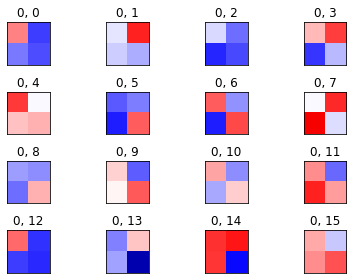

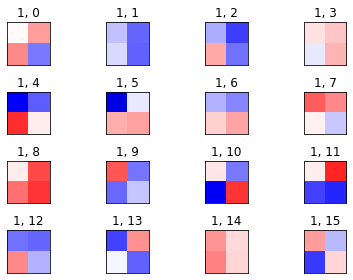

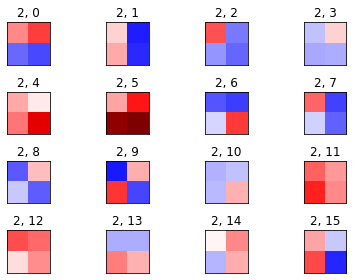

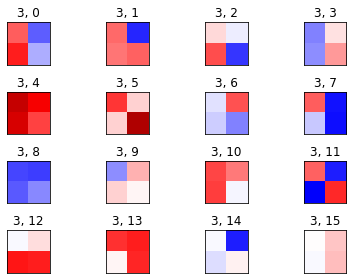

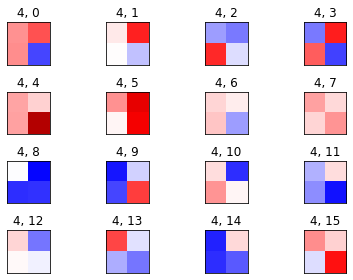

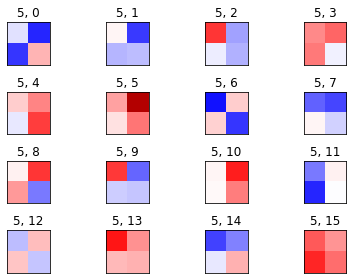

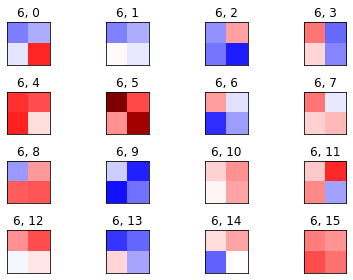

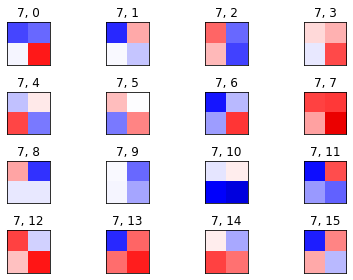

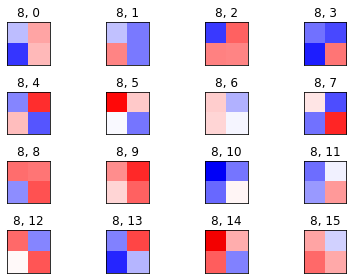

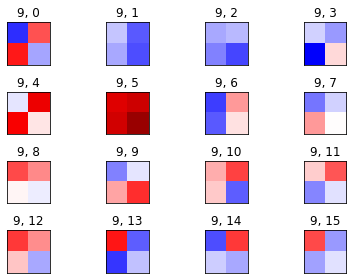

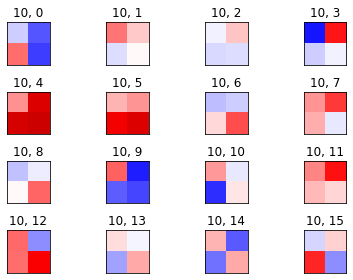

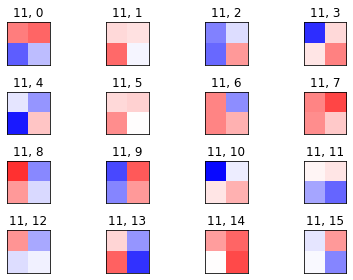

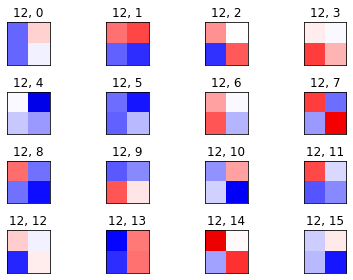

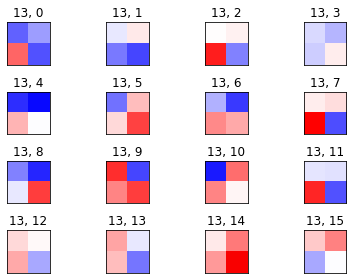

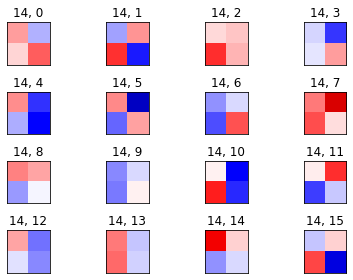

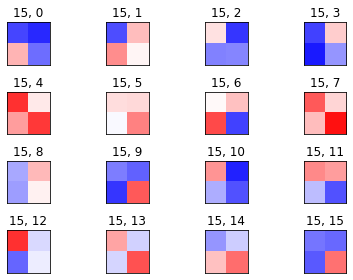

In [43]:
num_filters = conv_x2_kernel_np.shape[2]
channels = range(conv_x2_kernel_np.shape[2])
w_max = np.max(conv_x2_kernel_np)
w_min = np.min(conv_x2_kernel_np)

for channel in channels:
    # create figure and axes
    fig, axes = plt.subplots(4, 4)
    for idx, ax in enumerate(axes.flat):
        img = conv_x2_kernel_np[:, :, channel, idx]
        _ = ax.imshow(img, vmin=w_min, vmax=w_max, 
                      interpolation='nearest', cmap='seismic')
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.set_title(f'{channel}, {idx}')
    fig.tight_layout()

In [ ]:

# iterate channels
for channel in channels:
    # iterate filters inside every channel
    for l, ax in enumerate(axes.flat):
        # get a single filter
        img = weights[:, :, channel, l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
    # save figure
    plt.savefig(os.path.join(plot_dir, '{}-{}.png'.format(name, channel)), bbox_inches='tight')

[]

[]

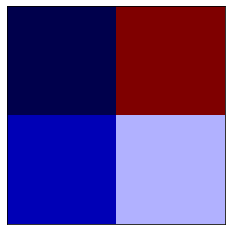

In [29]:
w0 = conv_x1_kernel_np[:, :, 0]
w_min = np.min(w0)
w_max = np.max(w0)

fig, ax = plt.subplots()
_ = ax.imshow(conv_x1_kernel_np[:, :, 0], vmin=w_min, vmax=w_max, 
          interpolation='nearest', cmap='seismic')
# remove any labels from the axes
_ = ax.set_xticks([])
_ = ax.set_yticks([])

In [ ]:
model.dynamics.position_fn.dense

In [39]:
import pickle

with open(model.files['parameters_pkl_file'], 'wb') as f:
    pickle.dump(model.params, f)

In [ ]:
model.sess.graph.collections

In [ ]:
model.sess.graph.get_collection

In [ ]:
model.dynamics.position_fn.summary()

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(model.lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
_ = helpers.plot_run_data(model.data, 
                          model.params, 
                          model.steps_arr, 
                          model.figs_dir, 
                          skip_steps=1)

In [ ]:
#tf.reset_default_graph()
#model = GaugeModel(params=params,
#                   config=None,
#                   sess=None,
#                   conv_net=False,
#                   hmc=False,
#                   log_dir='../../gauge_logs_graph/run_25',
#                   restore=True)

In [ ]:
samples = np.random.randn(*model.samples.shape)
samples_history = []

In [ ]:
for i in range(500):
    t0 = time.time()
    samples = model.sess.run(model.x_out, feed_dict={model.x: samples})
    samples_history.append(samples)
    print(f'step: {i:^6.4g} time/step: {time.time() - t0:^6.4g}')

In [ ]:
samples_history_conv = np.array(samples_history_conv)
print(samples_history_conv.shape)

In [ ]:
import pickle
samples_history_file = os.path.join(model.info_dir, 'samples_history.pkl')
with open(samples_history_file, 'wb') as f:
    pickle.dump(samples_history_conv, f)